## VP project - Gianfranco Di Marco - 1962292
\
**RRU-Net: The Ringed Residual U-Net for Image Splicing Forgery Detection**
*   X. Bi, Y. Wei, B. Xiao and W. Li, "RRU-Net: *The Ringed Residual U-Net for Image Splicing Forgery Detection*" 2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), 2019, pp. 30-39, doi: 10.1109/CVPRW.2019.00010.


\
This project is an implementation in Tensorflow 2.0 of the above paper with a new Dataset: **Splicing COCO Dataset** (named by the author "Spliced Nist"); this can be found at the following link:

> https://github.com/jawadbappy/forgery_localization_HLED/tree/master/synthetic_data

\
The images of this dataset have been obtained from the pristine images of the MFC18 challenge, spliced with an object from the COCO Dataset. In particular, for this project, I used 180 images in total: 125 for the training set, 10 for the validation set and 45 for the test set. Here are the main citations for this data:

*   Bappy, Jawadul H and Simons, Cody and Nataraj, Lakshmanan and Manjunath, BS and Roy-Chowdhury, Amit K, "*Hybrid LSTM and Encoder-Decoder Architecture for Detection of Image Forgeries*", IEEE Transactions on Image Processing, 2019







## Requirements

**Repository**

In [1]:
!git clone https://github.com/Gianfranco-98/RRU-Net_Tensorflow2.git
!mv RRU-Net_Tensorflow2/* /content
!rm LICENSE
!rm README.md   
!rm -r RRU-Net_Tensorflow2

Cloning into 'RRU-Net_Tensorflow2'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 98 (delta 50), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (98/98), done.


**Libraries**

In [2]:
!pip install tensorflow-addons
!pip install --upgrade tensorflow
!pip install --upgrade albumentations
!apt-get update
!apt install imagemagick

     |████████████████████████████████| 679 kB 8.5 MB/s 
     |████████████████████████████████| 98 kB 5.4 MB/s 
     |████████████████████████████████| 37.1 MB 46 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InR

In [3]:
# Parameters
from configuration import *

# Dataset
from dataset import *

# Math
import numpy as np
from random import choice

# Images
import cv2
import skimage
from skimage import io
import matplotlib.pyplot as plt

# Learning
from net import *
import tensorflow as tf
import tensorflow_addons as tfa

# File management
import os
from google.colab import drive
from google.colab import output

# Time management
import time

# Other tools
from functools import partial
from tqdm import tqdm

## Dataset

**Generation**

In [ ]:
if DATASET_NAME == "Realistic_Tampering_Dataset":

    # 0. Initialization
    DATA_DIR = "./data"
    PRISTINE_FOLDER = "Pristine"
    FORGERED_FOLDER = "Forgered"
    GROUND_TRUTH_FOLDER = "Ground_Truth"
    DATASET_DIR = '/content/drive/MyDrive/VP_Project/data/' + DATASET_NAME
    drive.mount("/content/drive", force_remount=True)
    start_time = time.time()

    # 1. Directory creation
    %cd /content
    !mkdir data

    # 2. Extraction
    %cd $DATASET_DIR
    print("Dataset extraction...")
    ZIPFILE = DATASET_NAME + '.zip'
    !unzip $ZIPFILE -d /content/data

    # 3. Conversion TIFF (PNG) -> JPEG with 100% quality
    %cd /content/data
    print("Conversion to JPEG with 100% quality")
    %cd $DATASET_NAME
    %cd $PRISTINE_FOLDER
    !for f in *.TIF; do  echo "Converting $f"; convert -quality 100 "$f"  "$(basename "$f" .TIF).jpg"; done
    !rm *.TIF
    %cd ..
    %cd $FORGERED_FOLDER
    !for f in *.TIF; do  echo "Converting $f"; convert -quality 100 "$f"  "$(basename "$f" .TIF).jpg"; done
    !rm *.TIF
    %cd ..
    %cd $GROUND_TRUTH_FOLDER
    !for f in *.PNG; do  echo "Converting $f"; convert -quality 100 "$f"  "$(basename "$f" .PNG).jpg"; done
    !rm *.PNG

    # Time computation
    print("Dataset generation completed in %fs" % (time.time() - start_time))

    %cd /content

In [ ]:
if DATASET_NAME == "CASIA":

    # 1. Download Dataset
    start_time = time.time()
    %cd /content
    !mkdir data
    %cd data
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IDUgcoUeonBxx2rASX-_QwV9fhbtqdY8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1IDUgcoUeonBxx2rASX-_QwV9fhbtqdY8" -O 'CASIA2.0_revised.zip' && rm -rf /tmp/cookies.txt
    output.clear()

    # 2. Extract Dataset
    print("Dataset extraction...")
    ZIPFILE = 'CASIA2.0_revised' + '.zip'
    !unzip -q $ZIPFILE
    !mv CASIA2.0_revised CASIA
    !rm CASIA2.0_revised.zip
    output.clear()

    # 3. Generate GT
    print("Generating Ground Truth...")
    %cd CASIA
    !git clone https://github.com/namtpham/casia2groundtruth.git
    !mv /content/data/CASIA/casia2groundtruth/CASIA2.0_Groundtruth.zip /content/data/CASIA/
    !rm -r casia2groundtruth
    ZIPFILE = 'CASIA2.0_Groundtruth' + '.zip'
    !unzip -q $ZIPFILE
    !mv CASIA2.0_Groundtruth Gt
    !rm CASIA2.0_Groundtruth.zip
    output.clear()
 
    # 4. Select randomly 760 images
    %cd Tp       
    print("Selecting 760 images and removing the others...")
    files = os.listdir('.')
    indices = random.sample(range(len(files)), k=DATASET_SIZE)
    for i, f in enumerate(tqdm(files)):
        if i not in indices:
            gt_f = '../Gt/' + f.replace(f[-4:], '_gt.png')
            !rm $f
            !rm $gt_f
    output.clear()

    # Time computation
    print("Dataset generation completed in %fs" % (time.time() - start_time))

    %cd /content

In [4]:
if DATASET_NAME == "Spliced_COCO":
    # 1. Download Dataset
    start_time = time.time()
    %cd /content
    !mkdir data
    %cd data
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11cp_lomeTQUqRCJslMtXJbSHqCz8ir5P' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11cp_lomeTQUqRCJslMtXJbSHqCz8ir5P" -O 'Spliced_COCO.zip' && rm -rf /tmp/cookies.txt
    output.clear()

    # 2. Extract Dataset
    print("Dataset extraction...")
    ZIPFILE = 'Spliced_COCO' + '.zip'
    !unzip -q $ZIPFILE
    !rm Spliced_COCO.zip
    %cd /content
    output.clear()

    # Time computation
    print("Dataset generation completed in %fs" % (time.time() - start_time))

Dataset generation completed in 14.261624s


**Data Augmentation**

In [5]:
path_img = DATA_DIR + DATASET_NAME + '/' + FORGERED_FOLDER
path_mask = DATA_DIR + DATASET_NAME + '/' + GROUND_TRUTH_FOLDER
files = os.listdir(path_img)
pngs =  [f[:-4] for f in files if f[-3:] == 'png']
jpegs = [f[:-4] for f in files if f[-3:] == 'jpg']
tiffs = [f[:-4] for f in files if f[-3:] == 'tif']
print(len(files), "files")
print(len(pngs), "pngs")
print(len(tiffs), "tiffs")
print(len(jpegs), "jpegs")

180 files
180 pngs
0 tiffs
0 jpegs


In [6]:
from albumentations.augmentations.transforms import (
    VerticalFlip, HorizontalFlip, JpegCompression, GaussNoise)
import os
import shutil

ids = [f[:-4] for f in os.listdir(path_img)]
random.shuffle(ids)
completedata = {
    'train': ids[:TRAIN_SIZE], 
    'val': ids[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE], 
    'test': ids[TRAIN_SIZE+VAL_SIZE:]
}

train_set = [f for f in os.listdir(path_img) if f[:-4] in completedata['train']]
val_set = [f for f in os.listdir(path_img) if f[:-4] in completedata['val']]
test_set = [f for f in os.listdir(path_img) if f[:-4] in completedata['test']]

In [7]:
# Convert all files possible to jpg
for i in tqdm(files):               
    name = i.split('.')[0]
    img = os.path.join(path_img, i)
    image = io.imread(img) 
    if '.jpg' not in i: 
        if image.shape[-1] == 4: 
            image = skimage.color.rgba2rgb(image) 
        io.imsave(os.path.join(path_img, '{}.jpg'.format(name)), image, quality=100)

# Remove all png files
if DATASET_NAME == 'CASIA':
    !rm /content/data/CASIA/Tp/*.tif
elif DATASET_NAME == 'Spliced_COCO':
    !rm /content/data/Spliced_COCO/Tp/*.png

# Convert unconvertible tiffs (PTIFFS)
if len(tiffs) > 0:
    %cd /content/data/CASIA/Tp
    for f in tiffs:
        if f not in jpegs:
            f = f + '.tif'
            print("Converting", f)
            !convert -quality 100 "$f"  "$(basename "$f" .tif).jpg"

    ## Remove bad files
    print("\n\nRemoving or replacing bad files...\n")
    for filename in tqdm(os.listdir('.')):
        if '-0' in filename:
            newname = filename.replace('-0', '')
            !mv $filename $newname
        elif '-' in filename:
            !rm $filename
    !rm /content/data/CASIA/Tp/*.tif

output.clear()

In [ ]:
# See issue https://github.com/yelusaleng/RRU-Net/issues/9
# N.B: Don't execute if you want to test Noise and Compression attacks

if DATASET_NAME == 'CASIA':
    train_set = [f.replace('.tif', '.jpg') for f in train_set]
elif DATASET_NAME == 'Spliced_COCO':
    train_set = [f.replace('.png', '.jpg') for f in train_set]

for i in tqdm(train_set):
    name = i.split('.')[0]
    img = os.path.join(path_img, i) 
    mask = os.path.join(path_mask, '{}_gt.png'.format(name)) 
    image = io.imread(img) 
    mask = io.imread(mask)

    list_quality = [50, 60, 70, 80, 90]
    quality = choice(list_quality)
    io.imsave(os.path.join(path_img, '{}_q.jpg'.format(name)), image, quality=quality)
    io.imsave(os.path.join(path_mask, '{}_q_gt.png'.format(name)), mask)

    whatever_data = "my name"

    augmentation = VerticalFlip(p=1.0)
    data = {"image": image, "mask": mask, "whatever_data": whatever_data, "additional": "hello"}
    augmented = augmentation(**data)
    image_ver, mask_ver, whatever_data, additional = augmented["image"], augmented["mask"], augmented["whatever_data"], augmented["additional"]
    io.imsave(os.path.join(path_img, '{}_ver.jpg'.format(name)), image_ver, quality=100)
    io.imsave(os.path.join(path_mask, '{}_ver_gt.png'.format(name)), mask_ver)

    augmentation = HorizontalFlip(p=1.0)
    data = {"image": image, "mask": mask, "whatever_data": whatever_data, "additional": "hello"}
    augmented = augmentation(**data)
    image_hor, mask_hor, whatever_data, additional = augmented["image"], augmented["mask"], augmented["whatever_data"], augmented["additional"]
    io.imsave(os.path.join(path_img, '{}_hor.jpg'.format(name)), image_hor, quality=100)
    io.imsave(os.path.join(path_mask, '{}_hor_gt.png'.format(name)), mask_hor)

    augmentation = GaussNoise(var_limit=(10, 50), p=1.0)
    data = {"image": image, "mask": mask, "whatever_data": whatever_data, "additional": "hello"}
    augmented = augmentation(**data)
    image_g, mask_g, whatever_data, additional = augmented["image"], augmented["mask"], augmented["whatever_data"], augmented["additional"]
    io.imsave(os.path.join(path_img, '{}_G.jpg'.format(name)), image_g, quality=100)
    io.imsave(os.path.join(path_mask, '{}_G_gt.png'.format(name)), mask_g)

## Main program

**Dataset initialization**

In [8]:
path_img = DATA_DIR + DATASET_NAME + '/' + FORGERED_FOLDER
ids = [f[:-4] for f in os.listdir(path_img)]
val_ids = [id for id in ids if (id[-1]!='q' and id[-1]!='r' and id[-1]!='G')]
random.shuffle(val_ids)
val_ids = val_ids[:VAL_SIZE+TEST_SIZE]
train_ids = [id for id in ids if id not in val_ids]
test_ids = val_ids[VAL_SIZE:]
val_ids = val_ids[:VAL_SIZE]
random.shuffle(train_ids)
completedata = {'train': train_ids, 'val': val_ids, 'test': test_ids}

In [9]:
print(len(completedata['train']))
print(len(completedata['val']))
print(len(completedata['test']))

125
10
45


In [10]:
def train_dataset_regenerate(ids):
    random.shuffle(ids)
    train_generator = partial(Forgery_Detection_Dataset(ids).generate, mode='train')
    train_dataset = tf.data.Dataset.from_generator(
        train_generator,
        output_signature=(
            tf.TensorSpec(shape=IMG_SHAPE[::-1]+(IMG_CHANNELS,), dtype=tf.float32),
            tf.TensorSpec(shape=IMG_SHAPE[::-1]+(IMG_CHANNELS,), dtype=tf.float32)
        )
    )
    train_dataset = train_dataset.batch(BATCH_SIZE)
    return train_dataset

In [11]:
## Train dataset --------------------------------------------------------------------------
print("Train dataset generation ...")
train_generator = partial(Forgery_Detection_Dataset(train_ids).generate, mode='train')
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=IMG_SHAPE[::-1]+(IMG_CHANNELS,), dtype=tf.float32),
        tf.TensorSpec(shape=IMG_SHAPE[::-1]+(IMG_CHANNELS,), dtype=tf.float32)
    )
)
train_dataset = train_dataset.batch(BATCH_SIZE)

## Validation dataset ---------------------------------------------------------------------
print("Validation dataset generation ...")
val_generator = partial(Forgery_Detection_Dataset(val_ids).generate, mode='val')
val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_signature=(
        tf.TensorSpec(shape=IMG_SHAPE[::-1]+(IMG_CHANNELS,), dtype=tf.float32),
        tf.TensorSpec(shape=IMG_SHAPE[::-1]+(IMG_CHANNELS,), dtype=tf.float32)
    )
)
val_dataset = val_dataset.batch(BATCH_SIZE)

## Test dataset ----------------------------------------------------------------------------
print("Test dataset generation ...")
test_generator = partial(Forgery_Detection_Dataset(test_ids).generate, mode='test')
test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=IMG_SHAPE[::-1]+(IMG_CHANNELS,), dtype=tf.float32),
        tf.TensorSpec(shape=IMG_SHAPE[::-1]+(IMG_CHANNELS,), dtype=tf.float32),
    )
)
test_dataset = test_dataset.batch(BATCH_SIZE)

Train dataset generation ...
Validation dataset generation ...
Test dataset generation ...


**Network initialization**

In [12]:
LOAD_MODEL = True
CHECKPOINT_PERIOD = 10
CHECKPOINT_FILEPATH = '/content/drive/MyDrive/RRU_Checkpoints/3/'
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [13]:
rru_net = RRU_Net(n_channels=3, n_classes=1)
boundaries = [50*len(train_ids)/BATCH_SIZE, 100*len(train_ids)/BATCH_SIZE]
values = [LEARNING_RATE, LEARNING_RATE*0.1, LEARNING_RATE*0.01]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
rru_optimizer = tfa.optimizers.SGDW(WEIGHT_DECAY, learning_rate_fn, MOMENTUM)
loss = tf.keras.losses.BinaryCrossentropy()
checkpoint = tf.train.Checkpoint(rru_net)

if LOAD_MODEL:
    latest = tf.train.latest_checkpoint(CHECKPOINT_FILEPATH)
    rru_net.load_weights(latest)    
    # last_epoch = SET IF YOU NEED TO CONTINUE OLD TRAINING
    # N.B: FOR THE GRAPHS, DON'T FORGET TO RESTORE ALSO THE FILES TRAIN_LOSSES, MAX_SIGMOIDED AND F1_SCORES
else:
    last_epoch = 0

**Train**

_____ Train Epoch 0 _____
Epoch 0 | Batch 0 - Train loss = 0.626704 - Max mask value = 1.000000
Epoch 0 | Batch 1 - Train loss = 0.485776 - Max mask value = 0.999988
Epoch 0 | Batch 2 - Train loss = 0.321737 - Max mask value = 0.999919
Epoch 0 | Batch 3 - Train loss = 0.241225 - Max mask value = 0.999343
Epoch 0 | Batch 4 - Train loss = 0.219721 - Max mask value = 0.988996
Epoch 0 | Batch 5 - Train loss = 0.196461 - Max mask value = 0.995450
Epoch 0 | Batch 6 - Train loss = 0.164350 - Max mask value = 0.907497
Epoch 0 | Batch 7 - Train loss = 0.146476 - Max mask value = 0.964093
Epoch 0 | Batch 8 - Train loss = 0.172395 - Max mask value = 0.941649
Epoch 0 | Batch 9 - Train loss = 0.095011 - Max mask value = 0.966509
Epoch 0 | Batch 10 - Train loss = 0.055070 - Max mask value = 0.981872
Epoch 0 | Batch 11 - Train loss = 0.062278 - Max mask value = 0.990759
Epoch 0 | Batch 12 - Train loss = 0.130706 - Max mask value = 0.982700
Epoch 0 | Batch 13 - Train loss = 0.075432 - Max mask value =

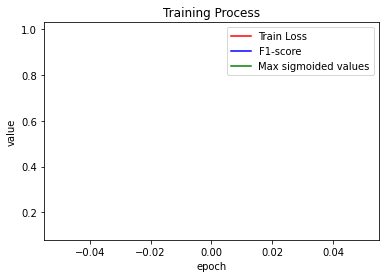

_____ Train Epoch 1 _____
Epoch 1 | Batch 0 - Train loss = 0.170257 - Max mask value = 0.998020
Epoch 1 | Batch 1 - Train loss = 0.082734 - Max mask value = 0.999998
Epoch 1 | Batch 2 - Train loss = 0.111977 - Max mask value = 0.995542
Epoch 1 | Batch 3 - Train loss = 0.111558 - Max mask value = 0.998673
Epoch 1 | Batch 4 - Train loss = 0.138212 - Max mask value = 0.999938
Epoch 1 | Batch 5 - Train loss = 0.065008 - Max mask value = 0.999768
Epoch 1 | Batch 6 - Train loss = 0.064841 - Max mask value = 0.999819
Epoch 1 | Batch 7 - Train loss = 0.081240 - Max mask value = 0.997996
Epoch 1 | Batch 8 - Train loss = 0.088316 - Max mask value = 0.987256
Epoch 1 | Batch 9 - Train loss = 0.098174 - Max mask value = 0.972980
Epoch 1 | Batch 10 - Train loss = 0.125805 - Max mask value = 0.996167
Epoch 1 | Batch 11 - Train loss = 0.226090 - Max mask value = 0.997417
Epoch 1 | Batch 12 - Train loss = 0.094795 - Max mask value = 0.998994
Epoch 1 | Batch 13 - Train loss = 0.115197 - Max mask value =

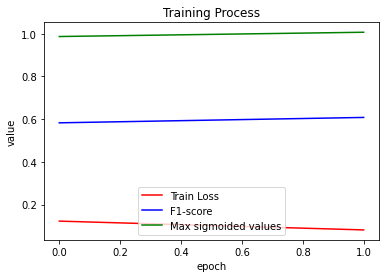

_____ Train Epoch 2 _____
Epoch 2 | Batch 0 - Train loss = 0.043369 - Max mask value = 0.999907
Epoch 2 | Batch 1 - Train loss = 0.060197 - Max mask value = 0.996643
Epoch 2 | Batch 2 - Train loss = 0.052137 - Max mask value = 0.999999
Epoch 2 | Batch 3 - Train loss = 0.072905 - Max mask value = 0.997746
Epoch 2 | Batch 4 - Train loss = 0.035749 - Max mask value = 0.998573
Epoch 2 | Batch 5 - Train loss = 0.072234 - Max mask value = 0.999969
Epoch 2 | Batch 6 - Train loss = 0.051430 - Max mask value = 0.999837
Epoch 2 | Batch 7 - Train loss = 0.061638 - Max mask value = 0.999790
Epoch 2 | Batch 8 - Train loss = 0.068119 - Max mask value = 0.999924
Epoch 2 | Batch 9 - Train loss = 0.044270 - Max mask value = 0.999989
Epoch 2 | Batch 10 - Train loss = 0.044983 - Max mask value = 0.999893
Epoch 2 | Batch 11 - Train loss = 0.123396 - Max mask value = 0.999857
Epoch 2 | Batch 12 - Train loss = 0.119789 - Max mask value = 0.999946
Epoch 2 | Batch 13 - Train loss = 0.086597 - Max mask value =

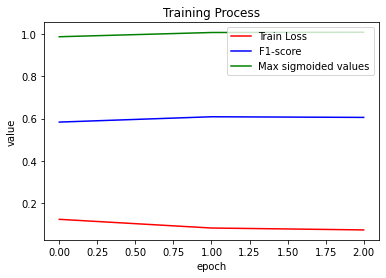

_____ Train Epoch 3 _____
Epoch 3 | Batch 0 - Train loss = 0.086994 - Max mask value = 0.999920
Epoch 3 | Batch 1 - Train loss = 0.053772 - Max mask value = 0.999890
Epoch 3 | Batch 2 - Train loss = 0.109344 - Max mask value = 0.999912
Epoch 3 | Batch 3 - Train loss = 0.052767 - Max mask value = 0.999498
Epoch 3 | Batch 4 - Train loss = 0.034969 - Max mask value = 0.999908
Epoch 3 | Batch 5 - Train loss = 0.044203 - Max mask value = 0.999987
Epoch 3 | Batch 6 - Train loss = 0.054356 - Max mask value = 0.997075
Epoch 3 | Batch 7 - Train loss = 0.100684 - Max mask value = 0.995352
Epoch 3 | Batch 8 - Train loss = 0.074874 - Max mask value = 0.987109
Epoch 3 | Batch 9 - Train loss = 0.062796 - Max mask value = 0.999009
Epoch 3 | Batch 10 - Train loss = 0.039616 - Max mask value = 0.995385
Epoch 3 | Batch 11 - Train loss = 0.086970 - Max mask value = 0.999341
Epoch 3 | Batch 12 - Train loss = 0.065551 - Max mask value = 0.999988
Epoch 3 | Batch 13 - Train loss = 0.083764 - Max mask value =

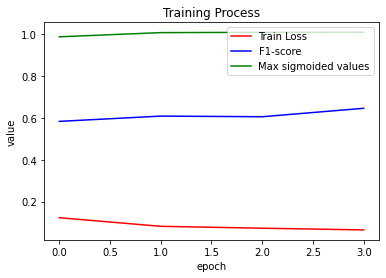

_____ Train Epoch 4 _____
Epoch 4 | Batch 0 - Train loss = 0.049710 - Max mask value = 0.999799
Epoch 4 | Batch 1 - Train loss = 0.043282 - Max mask value = 0.999988
Epoch 4 | Batch 2 - Train loss = 0.065403 - Max mask value = 0.999817
Epoch 4 | Batch 3 - Train loss = 0.088344 - Max mask value = 0.999993
Epoch 4 | Batch 4 - Train loss = 0.043499 - Max mask value = 0.999963
Epoch 4 | Batch 5 - Train loss = 0.110360 - Max mask value = 0.999793
Epoch 4 | Batch 6 - Train loss = 0.035547 - Max mask value = 0.999999
Epoch 4 | Batch 7 - Train loss = 0.070102 - Max mask value = 0.999991
Epoch 4 | Batch 8 - Train loss = 0.047260 - Max mask value = 0.999980
Epoch 4 | Batch 9 - Train loss = 0.057189 - Max mask value = 0.999998
Epoch 4 | Batch 10 - Train loss = 0.053625 - Max mask value = 0.999884
Epoch 4 | Batch 11 - Train loss = 0.039475 - Max mask value = 0.999981
Epoch 4 | Batch 12 - Train loss = 0.045377 - Max mask value = 0.999962
Epoch 4 | Batch 13 - Train loss = 0.040214 - Max mask value =

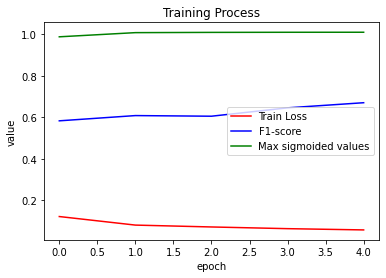

_____ Train Epoch 5 _____
Epoch 5 | Batch 0 - Train loss = 0.027874 - Max mask value = 0.999940
Epoch 5 | Batch 1 - Train loss = 0.074639 - Max mask value = 0.999331
Epoch 5 | Batch 2 - Train loss = 0.044919 - Max mask value = 0.999924
Epoch 5 | Batch 3 - Train loss = 0.028020 - Max mask value = 0.999976
Epoch 5 | Batch 4 - Train loss = 0.088718 - Max mask value = 0.998548
Epoch 5 | Batch 5 - Train loss = 0.053772 - Max mask value = 0.999998
Epoch 5 | Batch 6 - Train loss = 0.063039 - Max mask value = 0.999766
Epoch 5 | Batch 7 - Train loss = 0.043349 - Max mask value = 0.999967
Epoch 5 | Batch 8 - Train loss = 0.055694 - Max mask value = 0.999995
Epoch 5 | Batch 9 - Train loss = 0.065105 - Max mask value = 0.999875
Epoch 5 | Batch 10 - Train loss = 0.037392 - Max mask value = 0.999999
Epoch 5 | Batch 11 - Train loss = 0.033729 - Max mask value = 1.000000
Epoch 5 | Batch 12 - Train loss = 0.053344 - Max mask value = 1.000000
Epoch 5 | Batch 13 - Train loss = 0.042011 - Max mask value =

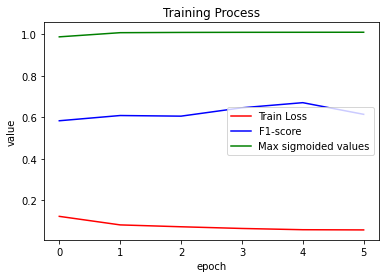

_____ Train Epoch 6 _____
Epoch 6 | Batch 0 - Train loss = 0.043554 - Max mask value = 0.999927
Epoch 6 | Batch 1 - Train loss = 0.044640 - Max mask value = 0.999902
Epoch 6 | Batch 2 - Train loss = 0.028194 - Max mask value = 1.000000
Epoch 6 | Batch 3 - Train loss = 0.057063 - Max mask value = 0.999878
Epoch 6 | Batch 4 - Train loss = 0.074208 - Max mask value = 1.000000
Epoch 6 | Batch 5 - Train loss = 0.062588 - Max mask value = 0.999106
Epoch 6 | Batch 6 - Train loss = 0.056619 - Max mask value = 0.999895
Epoch 6 | Batch 7 - Train loss = 0.049337 - Max mask value = 0.999994
Epoch 6 | Batch 8 - Train loss = 0.065098 - Max mask value = 0.999961
Epoch 6 | Batch 9 - Train loss = 0.041111 - Max mask value = 0.999997
Epoch 6 | Batch 10 - Train loss = 0.038611 - Max mask value = 0.999999
Epoch 6 | Batch 11 - Train loss = 0.073033 - Max mask value = 0.999967
Epoch 6 | Batch 12 - Train loss = 0.081941 - Max mask value = 0.999999
Epoch 6 | Batch 13 - Train loss = 0.061914 - Max mask value =

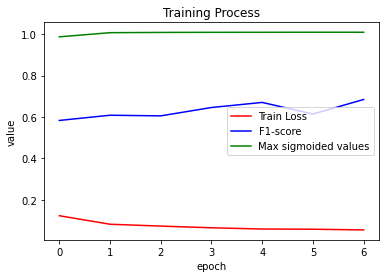

_____ Train Epoch 7 _____
Epoch 7 | Batch 0 - Train loss = 0.028083 - Max mask value = 0.999999
Epoch 7 | Batch 1 - Train loss = 0.024619 - Max mask value = 1.000000
Epoch 7 | Batch 2 - Train loss = 0.054363 - Max mask value = 0.999999
Epoch 7 | Batch 3 - Train loss = 0.027360 - Max mask value = 0.999993
Epoch 7 | Batch 4 - Train loss = 0.040626 - Max mask value = 0.999785
Epoch 7 | Batch 5 - Train loss = 0.025010 - Max mask value = 0.999989
Epoch 7 | Batch 6 - Train loss = 0.037305 - Max mask value = 0.999995
Epoch 7 | Batch 7 - Train loss = 0.029427 - Max mask value = 0.999997
Epoch 7 | Batch 8 - Train loss = 0.027836 - Max mask value = 0.999986
Epoch 7 | Batch 9 - Train loss = 0.045486 - Max mask value = 0.999808
Epoch 7 | Batch 10 - Train loss = 0.054761 - Max mask value = 0.998150
Epoch 7 | Batch 11 - Train loss = 0.037284 - Max mask value = 0.999999
Epoch 7 | Batch 12 - Train loss = 0.049028 - Max mask value = 0.999970
Epoch 7 | Batch 13 - Train loss = 0.036097 - Max mask value =

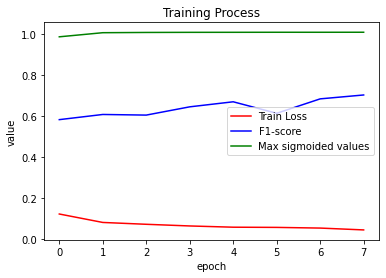

_____ Train Epoch 8 _____
Epoch 8 | Batch 0 - Train loss = 0.038983 - Max mask value = 0.999999
Epoch 8 | Batch 1 - Train loss = 0.055767 - Max mask value = 0.999960
Epoch 8 | Batch 2 - Train loss = 0.071548 - Max mask value = 0.999999
Epoch 8 | Batch 3 - Train loss = 0.026572 - Max mask value = 0.999998
Epoch 8 | Batch 4 - Train loss = 0.035432 - Max mask value = 0.999998
Epoch 8 | Batch 5 - Train loss = 0.021794 - Max mask value = 0.999988
Epoch 8 | Batch 6 - Train loss = 0.090370 - Max mask value = 0.999995
Epoch 8 | Batch 7 - Train loss = 0.036874 - Max mask value = 0.999969
Epoch 8 | Batch 8 - Train loss = 0.033941 - Max mask value = 0.999995
Epoch 8 | Batch 9 - Train loss = 0.057222 - Max mask value = 0.999947
Epoch 8 | Batch 10 - Train loss = 0.047872 - Max mask value = 0.999800
Epoch 8 | Batch 11 - Train loss = 0.054315 - Max mask value = 0.999983
Epoch 8 | Batch 12 - Train loss = 0.026094 - Max mask value = 1.000000
Epoch 8 | Batch 13 - Train loss = 0.026379 - Max mask value =

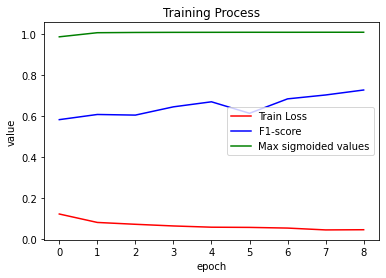

_____ Train Epoch 9 _____
Epoch 9 | Batch 0 - Train loss = 0.070503 - Max mask value = 1.000000
Epoch 9 | Batch 1 - Train loss = 0.035772 - Max mask value = 0.999997
Epoch 9 | Batch 2 - Train loss = 0.020331 - Max mask value = 0.999996
Epoch 9 | Batch 3 - Train loss = 0.019452 - Max mask value = 0.999999
Epoch 9 | Batch 4 - Train loss = 0.032866 - Max mask value = 0.999996
Epoch 9 | Batch 5 - Train loss = 0.057310 - Max mask value = 0.996506
Epoch 9 | Batch 6 - Train loss = 0.057807 - Max mask value = 0.999953
Epoch 9 | Batch 7 - Train loss = 0.040796 - Max mask value = 0.999968
Epoch 9 | Batch 8 - Train loss = 0.026768 - Max mask value = 0.999999
Epoch 9 | Batch 9 - Train loss = 0.059934 - Max mask value = 1.000000
Epoch 9 | Batch 10 - Train loss = 0.033740 - Max mask value = 0.999994
Epoch 9 | Batch 11 - Train loss = 0.033633 - Max mask value = 0.999950
Epoch 9 | Batch 12 - Train loss = 0.031286 - Max mask value = 0.999999
Epoch 9 | Batch 13 - Train loss = 0.020326 - Max mask value =

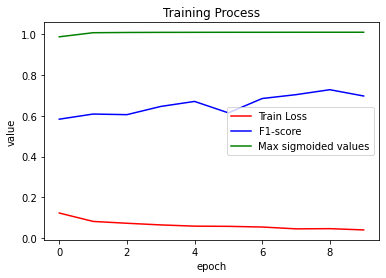

_____ Train Epoch 10 _____
Epoch 10 | Batch 0 - Train loss = 0.121796 - Max mask value = 0.999938
Epoch 10 | Batch 1 - Train loss = 0.077428 - Max mask value = 0.999990
Epoch 10 | Batch 2 - Train loss = 0.036736 - Max mask value = 0.999998
Epoch 10 | Batch 3 - Train loss = 0.026305 - Max mask value = 0.999804
Epoch 10 | Batch 4 - Train loss = 0.071871 - Max mask value = 0.999988
Epoch 10 | Batch 5 - Train loss = 0.046836 - Max mask value = 0.999936
Epoch 10 | Batch 6 - Train loss = 0.050076 - Max mask value = 1.000000
Epoch 10 | Batch 7 - Train loss = 0.040317 - Max mask value = 0.999934
Epoch 10 | Batch 8 - Train loss = 0.016732 - Max mask value = 0.999982
Epoch 10 | Batch 9 - Train loss = 0.043716 - Max mask value = 0.999704
Epoch 10 | Batch 10 - Train loss = 0.032105 - Max mask value = 0.995843
Epoch 10 | Batch 11 - Train loss = 0.098857 - Max mask value = 0.999989
Epoch 10 | Batch 12 - Train loss = 0.067719 - Max mask value = 0.999591
Epoch 10 | Batch 13 - Train loss = 0.036846 - M

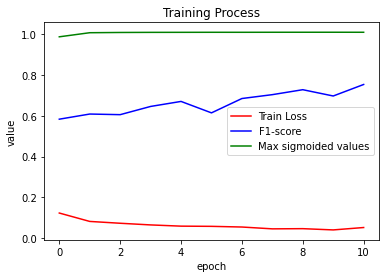

 - Saving Model...
_____ Train Epoch 11 _____
Epoch 11 | Batch 0 - Train loss = 0.069876 - Max mask value = 0.999998
Epoch 11 | Batch 1 - Train loss = 0.030381 - Max mask value = 1.000000
Epoch 11 | Batch 2 - Train loss = 0.081910 - Max mask value = 1.000000
Epoch 11 | Batch 3 - Train loss = 0.051437 - Max mask value = 0.999986
Epoch 11 | Batch 4 - Train loss = 0.050212 - Max mask value = 0.999853
Epoch 11 | Batch 5 - Train loss = 0.066784 - Max mask value = 0.999278
Epoch 11 | Batch 6 - Train loss = 0.052945 - Max mask value = 0.999792
Epoch 11 | Batch 7 - Train loss = 0.074208 - Max mask value = 0.998916
Epoch 11 | Batch 8 - Train loss = 0.044235 - Max mask value = 0.999907
Epoch 11 | Batch 9 - Train loss = 0.031945 - Max mask value = 1.000000
Epoch 11 | Batch 10 - Train loss = 0.024956 - Max mask value = 0.999997
Epoch 11 | Batch 11 - Train loss = 0.046029 - Max mask value = 1.000000
Epoch 11 | Batch 12 - Train loss = 0.052552 - Max mask value = 0.999844
Epoch 11 | Batch 13 - Train 

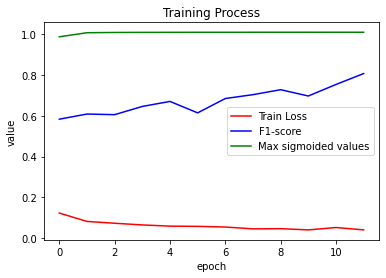

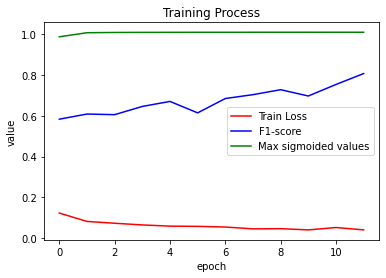

_____ Train Epoch 12 _____
_____ Train Epoch 12 _____
Epoch 12 | Batch 0 - Train loss = 0.089340 - Max mask value = 0.999960
Epoch 12 | Batch 0 - Train loss = 0.089340 - Max mask value = 0.999960
Epoch 12 | Batch 1 - Train loss = 0.021211 - Max mask value = 1.000000
Epoch 12 | Batch 1 - Train loss = 0.021211 - Max mask value = 1.000000
Epoch 12 | Batch 2 - Train loss = 0.061431 - Max mask value = 0.999999
Epoch 12 | Batch 2 - Train loss = 0.061431 - Max mask value = 0.999999
Epoch 12 | Batch 3 - Train loss = 0.017040 - Max mask value = 0.999966
Epoch 12 | Batch 3 - Train loss = 0.017040 - Max mask value = 0.999966
Epoch 12 | Batch 4 - Train loss = 0.015016 - Max mask value = 1.000000
Epoch 12 | Batch 4 - Train loss = 0.015016 - Max mask value = 1.000000
Epoch 12 | Batch 5 - Train loss = 0.019640 - Max mask value = 0.999997
Epoch 12 | Batch 5 - Train loss = 0.019640 - Max mask value = 0.999997
Epoch 12 | Batch 6 - Train loss = 0.031743 - Max mask value = 1.000000
Epoch 12 | Batch 6 - Tr

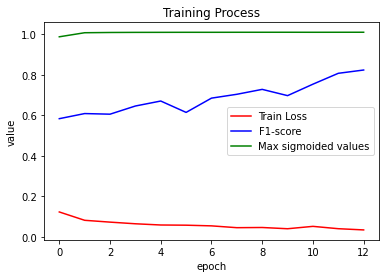

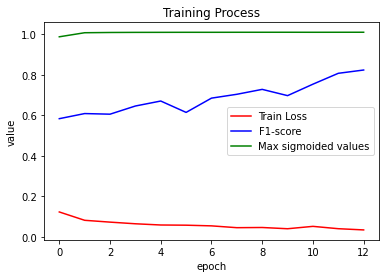

_____ Train Epoch 13 _____
_____ Train Epoch 13 _____
Epoch 13 | Batch 0 - Train loss = 0.033900 - Max mask value = 0.999992
Epoch 13 | Batch 0 - Train loss = 0.033900 - Max mask value = 0.999992
Epoch 13 | Batch 1 - Train loss = 0.028204 - Max mask value = 0.999997
Epoch 13 | Batch 1 - Train loss = 0.028204 - Max mask value = 0.999997
Epoch 13 | Batch 2 - Train loss = 0.022821 - Max mask value = 0.999999
Epoch 13 | Batch 2 - Train loss = 0.022821 - Max mask value = 0.999999
Epoch 13 | Batch 3 - Train loss = 0.044304 - Max mask value = 0.999995
Epoch 13 | Batch 3 - Train loss = 0.044304 - Max mask value = 0.999995
Epoch 13 | Batch 4 - Train loss = 0.063099 - Max mask value = 0.999879
Epoch 13 | Batch 4 - Train loss = 0.063099 - Max mask value = 0.999879
Epoch 13 | Batch 5 - Train loss = 0.016831 - Max mask value = 1.000000
Epoch 13 | Batch 5 - Train loss = 0.016831 - Max mask value = 1.000000
Epoch 13 | Batch 6 - Train loss = 0.046389 - Max mask value = 0.999969
Epoch 13 | Batch 6 - Tr

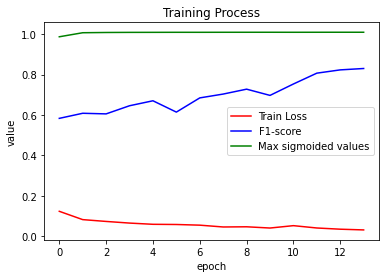

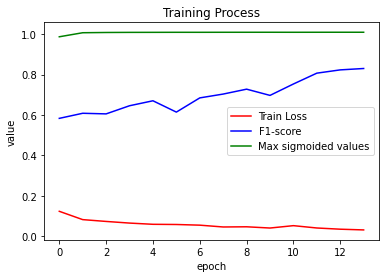

_____ Train Epoch 14 _____
_____ Train Epoch 14 _____
Epoch 14 | Batch 0 - Train loss = 0.029156 - Max mask value = 1.000000
Epoch 14 | Batch 0 - Train loss = 0.029156 - Max mask value = 1.000000
Epoch 14 | Batch 1 - Train loss = 0.033803 - Max mask value = 0.999961
Epoch 14 | Batch 1 - Train loss = 0.033803 - Max mask value = 0.999961
Epoch 14 | Batch 2 - Train loss = 0.020719 - Max mask value = 1.000000
Epoch 14 | Batch 2 - Train loss = 0.020719 - Max mask value = 1.000000
Epoch 14 | Batch 3 - Train loss = 0.022961 - Max mask value = 0.999907
Epoch 14 | Batch 3 - Train loss = 0.022961 - Max mask value = 0.999907
Epoch 14 | Batch 4 - Train loss = 0.021203 - Max mask value = 1.000000
Epoch 14 | Batch 4 - Train loss = 0.021203 - Max mask value = 1.000000
Epoch 14 | Batch 5 - Train loss = 0.017808 - Max mask value = 0.999995
Epoch 14 | Batch 5 - Train loss = 0.017808 - Max mask value = 0.999995
Epoch 14 | Batch 6 - Train loss = 0.032986 - Max mask value = 0.999985
Epoch 14 | Batch 6 - Tr

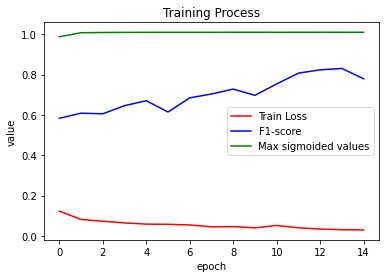

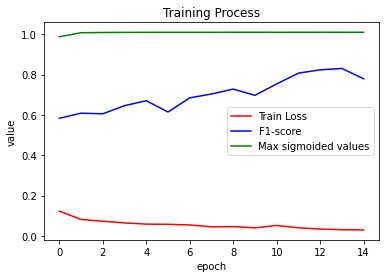

_____ Train Epoch 15 _____
_____ Train Epoch 15 _____
Epoch 15 | Batch 0 - Train loss = 0.052202 - Max mask value = 1.000000
Epoch 15 | Batch 0 - Train loss = 0.052202 - Max mask value = 1.000000
Epoch 15 | Batch 1 - Train loss = 0.041302 - Max mask value = 0.999998
Epoch 15 | Batch 1 - Train loss = 0.041302 - Max mask value = 0.999998
Epoch 15 | Batch 2 - Train loss = 0.055537 - Max mask value = 1.000000
Epoch 15 | Batch 2 - Train loss = 0.055537 - Max mask value = 1.000000
Epoch 15 | Batch 3 - Train loss = 0.029048 - Max mask value = 1.000000
Epoch 15 | Batch 3 - Train loss = 0.029048 - Max mask value = 1.000000
Epoch 15 | Batch 4 - Train loss = 0.025054 - Max mask value = 1.000000
Epoch 15 | Batch 4 - Train loss = 0.025054 - Max mask value = 1.000000
Epoch 15 | Batch 5 - Train loss = 0.021941 - Max mask value = 1.000000
Epoch 15 | Batch 5 - Train loss = 0.021941 - Max mask value = 1.000000
Epoch 15 | Batch 6 - Train loss = 0.055124 - Max mask value = 1.000000
Epoch 15 | Batch 6 - Tr

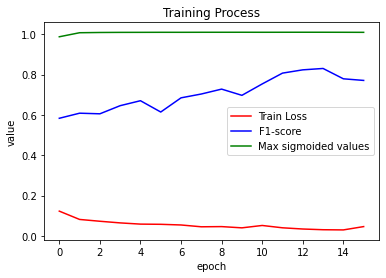

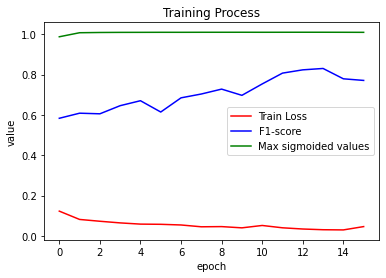

_____ Train Epoch 16 _____
_____ Train Epoch 16 _____
Epoch 16 | Batch 0 - Train loss = 0.027962 - Max mask value = 0.999636
Epoch 16 | Batch 0 - Train loss = 0.027962 - Max mask value = 0.999636
Epoch 16 | Batch 1 - Train loss = 0.053825 - Max mask value = 1.000000
Epoch 16 | Batch 1 - Train loss = 0.053825 - Max mask value = 1.000000
Epoch 16 | Batch 2 - Train loss = 0.031856 - Max mask value = 0.999980
Epoch 16 | Batch 2 - Train loss = 0.031856 - Max mask value = 0.999980
Epoch 16 | Batch 3 - Train loss = 0.117722 - Max mask value = 0.999999
Epoch 16 | Batch 3 - Train loss = 0.117722 - Max mask value = 0.999999
Epoch 16 | Batch 4 - Train loss = 0.027756 - Max mask value = 1.000000
Epoch 16 | Batch 4 - Train loss = 0.027756 - Max mask value = 1.000000
Epoch 16 | Batch 5 - Train loss = 0.073233 - Max mask value = 0.999968
Epoch 16 | Batch 5 - Train loss = 0.073233 - Max mask value = 0.999968
Epoch 16 | Batch 6 - Train loss = 0.024162 - Max mask value = 0.999984
Epoch 16 | Batch 6 - Tr

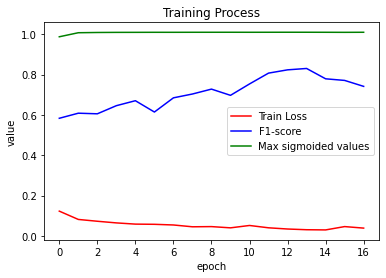

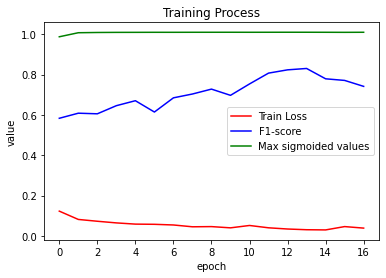

_____ Train Epoch 17 _____
_____ Train Epoch 17 _____
Epoch 17 | Batch 0 - Train loss = 0.057151 - Max mask value = 0.999788
Epoch 17 | Batch 0 - Train loss = 0.057151 - Max mask value = 0.999788
Epoch 17 | Batch 1 - Train loss = 0.030082 - Max mask value = 0.999989
Epoch 17 | Batch 1 - Train loss = 0.030082 - Max mask value = 0.999989
Epoch 17 | Batch 2 - Train loss = 0.022867 - Max mask value = 0.999993
Epoch 17 | Batch 2 - Train loss = 0.022867 - Max mask value = 0.999993
Epoch 17 | Batch 3 - Train loss = 0.039092 - Max mask value = 0.999964
Epoch 17 | Batch 3 - Train loss = 0.039092 - Max mask value = 0.999964
Epoch 17 | Batch 4 - Train loss = 0.032831 - Max mask value = 0.999991
Epoch 17 | Batch 4 - Train loss = 0.032831 - Max mask value = 0.999991
Epoch 17 | Batch 5 - Train loss = 0.021228 - Max mask value = 0.999997
Epoch 17 | Batch 5 - Train loss = 0.021228 - Max mask value = 0.999997
Epoch 17 | Batch 6 - Train loss = 0.037387 - Max mask value = 0.999998
Epoch 17 | Batch 6 - Tr

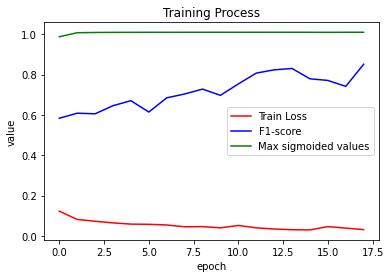

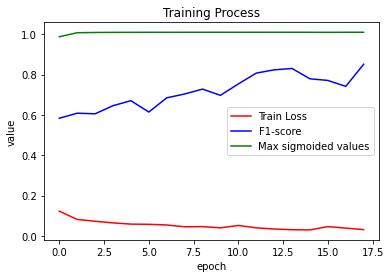

_____ Train Epoch 18 _____
_____ Train Epoch 18 _____
Epoch 18 | Batch 0 - Train loss = 0.031481 - Max mask value = 0.999999
Epoch 18 | Batch 0 - Train loss = 0.031481 - Max mask value = 0.999999
Epoch 18 | Batch 1 - Train loss = 0.035118 - Max mask value = 0.999818
Epoch 18 | Batch 1 - Train loss = 0.035118 - Max mask value = 0.999818
Epoch 18 | Batch 2 - Train loss = 0.035364 - Max mask value = 0.999995
Epoch 18 | Batch 2 - Train loss = 0.035364 - Max mask value = 0.999995
Epoch 18 | Batch 3 - Train loss = 0.013627 - Max mask value = 1.000000
Epoch 18 | Batch 3 - Train loss = 0.013627 - Max mask value = 1.000000
Epoch 18 | Batch 4 - Train loss = 0.036119 - Max mask value = 0.999741
Epoch 18 | Batch 4 - Train loss = 0.036119 - Max mask value = 0.999741
Epoch 18 | Batch 5 - Train loss = 0.011313 - Max mask value = 0.999984
Epoch 18 | Batch 5 - Train loss = 0.011313 - Max mask value = 0.999984
Epoch 18 | Batch 6 - Train loss = 0.022830 - Max mask value = 1.000000
Epoch 18 | Batch 6 - Tr

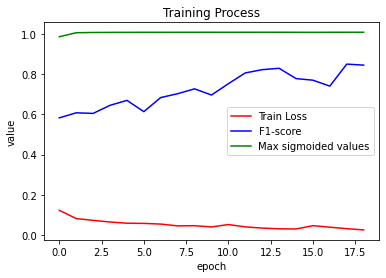

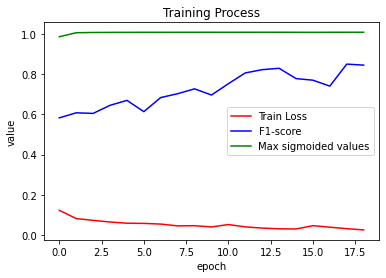

_____ Train Epoch 19 _____
_____ Train Epoch 19 _____
Epoch 19 | Batch 0 - Train loss = 0.019596 - Max mask value = 1.000000
Epoch 19 | Batch 0 - Train loss = 0.019596 - Max mask value = 1.000000
Epoch 19 | Batch 1 - Train loss = 0.060514 - Max mask value = 1.000000
Epoch 19 | Batch 1 - Train loss = 0.060514 - Max mask value = 1.000000
Epoch 19 | Batch 2 - Train loss = 0.031710 - Max mask value = 1.000000
Epoch 19 | Batch 2 - Train loss = 0.031710 - Max mask value = 1.000000
Epoch 19 | Batch 3 - Train loss = 0.015767 - Max mask value = 0.999968
Epoch 19 | Batch 3 - Train loss = 0.015767 - Max mask value = 0.999968
Epoch 19 | Batch 4 - Train loss = 0.025067 - Max mask value = 1.000000
Epoch 19 | Batch 4 - Train loss = 0.025067 - Max mask value = 1.000000
Epoch 19 | Batch 5 - Train loss = 0.018447 - Max mask value = 1.000000
Epoch 19 | Batch 5 - Train loss = 0.018447 - Max mask value = 1.000000
Epoch 19 | Batch 6 - Train loss = 0.040737 - Max mask value = 1.000000
Epoch 19 | Batch 6 - Tr

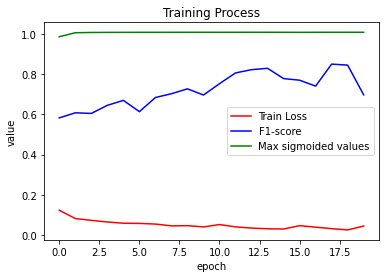

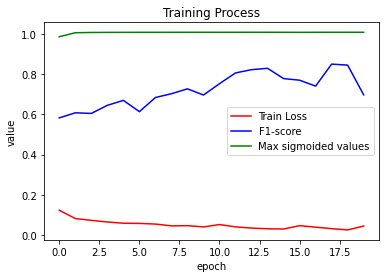

_____ Train Epoch 20 _____
_____ Train Epoch 20 _____
Epoch 20 | Batch 0 - Train loss = 0.046944 - Max mask value = 0.999002
Epoch 20 | Batch 0 - Train loss = 0.046944 - Max mask value = 0.999002
Epoch 20 | Batch 1 - Train loss = 0.054581 - Max mask value = 0.999522
Epoch 20 | Batch 1 - Train loss = 0.054581 - Max mask value = 0.999522
Epoch 20 | Batch 2 - Train loss = 0.048635 - Max mask value = 0.999604
Epoch 20 | Batch 2 - Train loss = 0.048635 - Max mask value = 0.999604
Epoch 20 | Batch 3 - Train loss = 0.071685 - Max mask value = 0.999844
Epoch 20 | Batch 3 - Train loss = 0.071685 - Max mask value = 0.999844
Epoch 20 | Batch 4 - Train loss = 0.041066 - Max mask value = 0.999619
Epoch 20 | Batch 4 - Train loss = 0.041066 - Max mask value = 0.999619
Epoch 20 | Batch 5 - Train loss = 0.056753 - Max mask value = 0.999815
Epoch 20 | Batch 5 - Train loss = 0.056753 - Max mask value = 0.999815
Epoch 20 | Batch 6 - Train loss = 0.033300 - Max mask value = 0.999995
Epoch 20 | Batch 6 - Tr

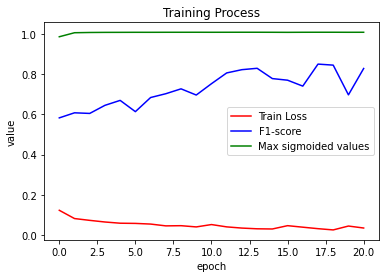

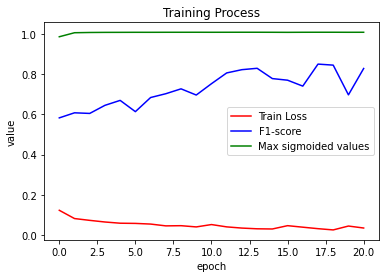

 - Saving Model...
 - Saving Model...
_____ Train Epoch 21 _____
_____ Train Epoch 21 _____
Epoch 21 | Batch 0 - Train loss = 0.022744 - Max mask value = 1.000000
Epoch 21 | Batch 0 - Train loss = 0.022744 - Max mask value = 1.000000
Epoch 21 | Batch 1 - Train loss = 0.034167 - Max mask value = 0.999984
Epoch 21 | Batch 1 - Train loss = 0.034167 - Max mask value = 0.999984
Epoch 21 | Batch 2 - Train loss = 0.035400 - Max mask value = 0.999791
Epoch 21 | Batch 2 - Train loss = 0.035400 - Max mask value = 0.999791
Epoch 21 | Batch 3 - Train loss = 0.022668 - Max mask value = 1.000000
Epoch 21 | Batch 3 - Train loss = 0.022668 - Max mask value = 1.000000
Epoch 21 | Batch 4 - Train loss = 0.018429 - Max mask value = 1.000000
Epoch 21 | Batch 4 - Train loss = 0.018429 - Max mask value = 1.000000
Epoch 21 | Batch 5 - Train loss = 0.018297 - Max mask value = 0.999998
Epoch 21 | Batch 5 - Train loss = 0.018297 - Max mask value = 0.999998
Epoch 21 | Batch 6 - Train loss = 0.014012 - Max mask va

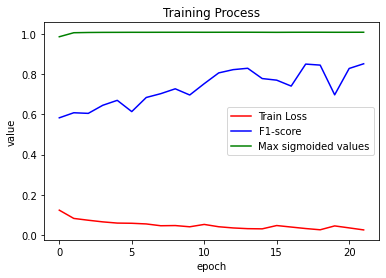

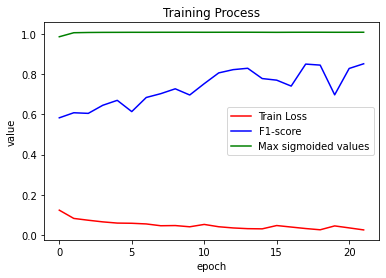

_____ Train Epoch 22 _____
_____ Train Epoch 22 _____
Epoch 22 | Batch 0 - Train loss = 0.013108 - Max mask value = 0.999999
Epoch 22 | Batch 0 - Train loss = 0.013108 - Max mask value = 0.999999
Epoch 22 | Batch 1 - Train loss = 0.029688 - Max mask value = 1.000000
Epoch 22 | Batch 1 - Train loss = 0.029688 - Max mask value = 1.000000
Epoch 22 | Batch 2 - Train loss = 0.025897 - Max mask value = 0.999998
Epoch 22 | Batch 2 - Train loss = 0.025897 - Max mask value = 0.999998
Epoch 22 | Batch 3 - Train loss = 0.042926 - Max mask value = 1.000000
Epoch 22 | Batch 3 - Train loss = 0.042926 - Max mask value = 1.000000
Epoch 22 | Batch 4 - Train loss = 0.018806 - Max mask value = 0.999999
Epoch 22 | Batch 4 - Train loss = 0.018806 - Max mask value = 0.999999
Epoch 22 | Batch 5 - Train loss = 0.052080 - Max mask value = 0.999998
Epoch 22 | Batch 5 - Train loss = 0.052080 - Max mask value = 0.999998
Epoch 22 | Batch 6 - Train loss = 0.029918 - Max mask value = 0.999999
Epoch 22 | Batch 6 - Tr

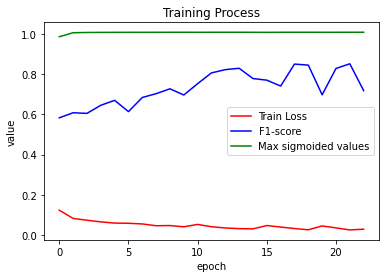

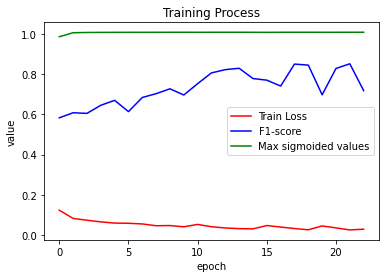

_____ Train Epoch 23 _____
_____ Train Epoch 23 _____
Epoch 23 | Batch 0 - Train loss = 0.029371 - Max mask value = 1.000000
Epoch 23 | Batch 0 - Train loss = 0.029371 - Max mask value = 1.000000
Epoch 23 | Batch 1 - Train loss = 0.045772 - Max mask value = 1.000000
Epoch 23 | Batch 1 - Train loss = 0.045772 - Max mask value = 1.000000
Epoch 23 | Batch 2 - Train loss = 0.027337 - Max mask value = 0.999972
Epoch 23 | Batch 2 - Train loss = 0.027337 - Max mask value = 0.999972
Epoch 23 | Batch 3 - Train loss = 0.026960 - Max mask value = 0.999993
Epoch 23 | Batch 3 - Train loss = 0.026960 - Max mask value = 0.999993
Epoch 23 | Batch 4 - Train loss = 0.022786 - Max mask value = 0.999977
Epoch 23 | Batch 4 - Train loss = 0.022786 - Max mask value = 0.999977
Epoch 23 | Batch 5 - Train loss = 0.040423 - Max mask value = 0.999988
Epoch 23 | Batch 5 - Train loss = 0.040423 - Max mask value = 0.999988
Epoch 23 | Batch 6 - Train loss = 0.038098 - Max mask value = 1.000000
Epoch 23 | Batch 6 - Tr

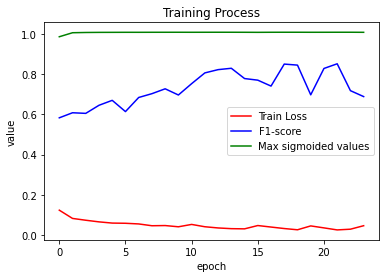

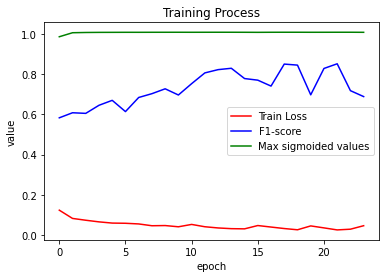

_____ Train Epoch 24 _____
_____ Train Epoch 24 _____
Epoch 24 | Batch 0 - Train loss = 0.069882 - Max mask value = 0.999999
Epoch 24 | Batch 0 - Train loss = 0.069882 - Max mask value = 0.999999
Epoch 24 | Batch 1 - Train loss = 0.053445 - Max mask value = 0.999948
Epoch 24 | Batch 1 - Train loss = 0.053445 - Max mask value = 0.999948
Epoch 24 | Batch 2 - Train loss = 0.041745 - Max mask value = 0.999994
Epoch 24 | Batch 2 - Train loss = 0.041745 - Max mask value = 0.999994
Epoch 24 | Batch 3 - Train loss = 0.035136 - Max mask value = 0.999962
Epoch 24 | Batch 3 - Train loss = 0.035136 - Max mask value = 0.999962
Epoch 24 | Batch 4 - Train loss = 0.027358 - Max mask value = 0.999913
Epoch 24 | Batch 4 - Train loss = 0.027358 - Max mask value = 0.999913
Epoch 24 | Batch 5 - Train loss = 0.040255 - Max mask value = 0.999979
Epoch 24 | Batch 5 - Train loss = 0.040255 - Max mask value = 0.999979
Epoch 24 | Batch 6 - Train loss = 0.095456 - Max mask value = 0.999931
Epoch 24 | Batch 6 - Tr

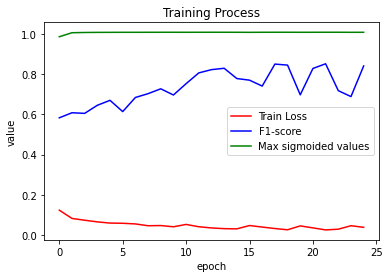

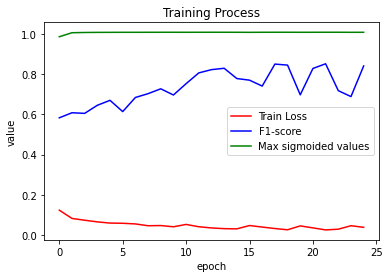

_____ Train Epoch 25 _____
_____ Train Epoch 25 _____
Epoch 25 | Batch 0 - Train loss = 0.011600 - Max mask value = 1.000000
Epoch 25 | Batch 0 - Train loss = 0.011600 - Max mask value = 1.000000
Epoch 25 | Batch 1 - Train loss = 0.021970 - Max mask value = 0.999979
Epoch 25 | Batch 1 - Train loss = 0.021970 - Max mask value = 0.999979
Epoch 25 | Batch 2 - Train loss = 0.046233 - Max mask value = 0.999991
Epoch 25 | Batch 2 - Train loss = 0.046233 - Max mask value = 0.999991
Epoch 25 | Batch 3 - Train loss = 0.052954 - Max mask value = 0.999999
Epoch 25 | Batch 3 - Train loss = 0.052954 - Max mask value = 0.999999
Epoch 25 | Batch 4 - Train loss = 0.026240 - Max mask value = 1.000000
Epoch 25 | Batch 4 - Train loss = 0.026240 - Max mask value = 1.000000
Epoch 25 | Batch 5 - Train loss = 0.030425 - Max mask value = 0.999999
Epoch 25 | Batch 5 - Train loss = 0.030425 - Max mask value = 0.999999
Epoch 25 | Batch 6 - Train loss = 0.021664 - Max mask value = 0.999999
Epoch 25 | Batch 6 - Tr

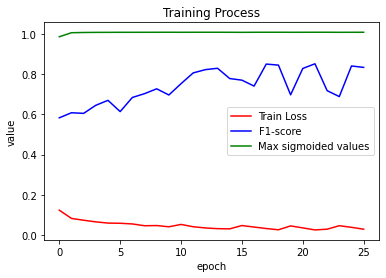

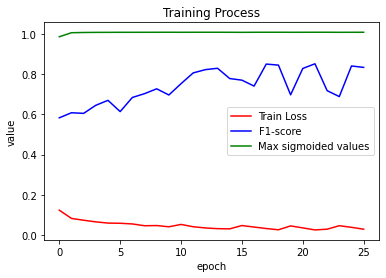

_____ Train Epoch 26 _____
_____ Train Epoch 26 _____
Epoch 26 | Batch 0 - Train loss = 0.031378 - Max mask value = 0.999991
Epoch 26 | Batch 0 - Train loss = 0.031378 - Max mask value = 0.999991
Epoch 26 | Batch 1 - Train loss = 0.011094 - Max mask value = 0.999999
Epoch 26 | Batch 1 - Train loss = 0.011094 - Max mask value = 0.999999
Epoch 26 | Batch 2 - Train loss = 0.012888 - Max mask value = 1.000000
Epoch 26 | Batch 2 - Train loss = 0.012888 - Max mask value = 1.000000
Epoch 26 | Batch 3 - Train loss = 0.015428 - Max mask value = 1.000000
Epoch 26 | Batch 3 - Train loss = 0.015428 - Max mask value = 1.000000
Epoch 26 | Batch 4 - Train loss = 0.018218 - Max mask value = 1.000000
Epoch 26 | Batch 4 - Train loss = 0.018218 - Max mask value = 1.000000
Epoch 26 | Batch 5 - Train loss = 0.013047 - Max mask value = 1.000000
Epoch 26 | Batch 5 - Train loss = 0.013047 - Max mask value = 1.000000
Epoch 26 | Batch 6 - Train loss = 0.030961 - Max mask value = 1.000000
Epoch 26 | Batch 6 - Tr

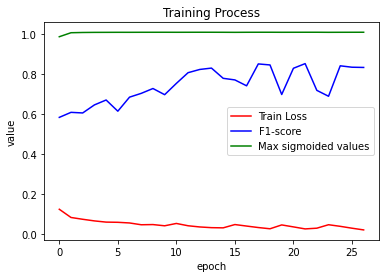

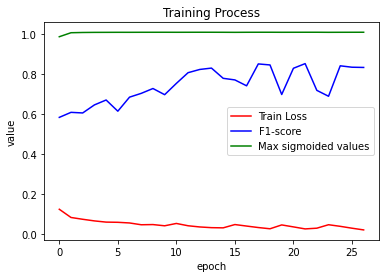

_____ Train Epoch 27 _____
_____ Train Epoch 27 _____
Epoch 27 | Batch 0 - Train loss = 0.028462 - Max mask value = 0.999999
Epoch 27 | Batch 0 - Train loss = 0.028462 - Max mask value = 0.999999
Epoch 27 | Batch 1 - Train loss = 0.032201 - Max mask value = 0.999996
Epoch 27 | Batch 1 - Train loss = 0.032201 - Max mask value = 0.999996
Epoch 27 | Batch 2 - Train loss = 0.018742 - Max mask value = 0.999999
Epoch 27 | Batch 2 - Train loss = 0.018742 - Max mask value = 0.999999
Epoch 27 | Batch 3 - Train loss = 0.016016 - Max mask value = 1.000000
Epoch 27 | Batch 3 - Train loss = 0.016016 - Max mask value = 1.000000
Epoch 27 | Batch 4 - Train loss = 0.009963 - Max mask value = 0.999965
Epoch 27 | Batch 4 - Train loss = 0.009963 - Max mask value = 0.999965
Epoch 27 | Batch 5 - Train loss = 0.014884 - Max mask value = 0.999974
Epoch 27 | Batch 5 - Train loss = 0.014884 - Max mask value = 0.999974
Epoch 27 | Batch 6 - Train loss = 0.025651 - Max mask value = 1.000000
Epoch 27 | Batch 6 - Tr

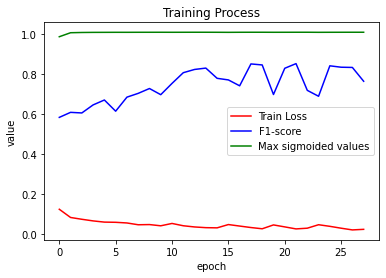

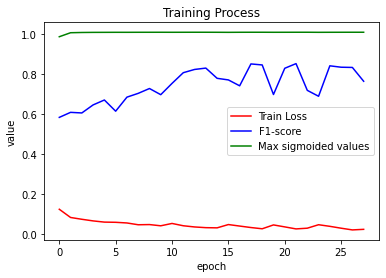

_____ Train Epoch 28 _____
_____ Train Epoch 28 _____
Epoch 28 | Batch 0 - Train loss = 0.048718 - Max mask value = 1.000000
Epoch 28 | Batch 0 - Train loss = 0.048718 - Max mask value = 1.000000
Epoch 28 | Batch 1 - Train loss = 0.027009 - Max mask value = 1.000000
Epoch 28 | Batch 1 - Train loss = 0.027009 - Max mask value = 1.000000
Epoch 28 | Batch 2 - Train loss = 0.009292 - Max mask value = 0.999998
Epoch 28 | Batch 2 - Train loss = 0.009292 - Max mask value = 0.999998
Epoch 28 | Batch 3 - Train loss = 0.038575 - Max mask value = 0.999999
Epoch 28 | Batch 3 - Train loss = 0.038575 - Max mask value = 0.999999
Epoch 28 | Batch 4 - Train loss = 0.012431 - Max mask value = 0.999939
Epoch 28 | Batch 4 - Train loss = 0.012431 - Max mask value = 0.999939
Epoch 28 | Batch 5 - Train loss = 0.025428 - Max mask value = 1.000000
Epoch 28 | Batch 5 - Train loss = 0.025428 - Max mask value = 1.000000
Epoch 28 | Batch 6 - Train loss = 0.027778 - Max mask value = 0.999969
Epoch 28 | Batch 6 - Tr

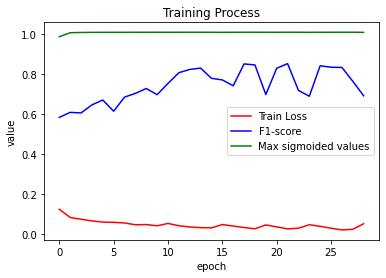

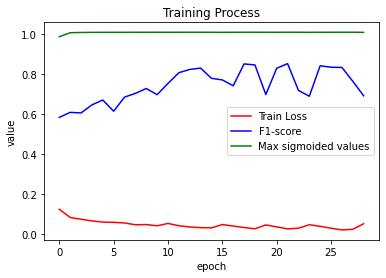

_____ Train Epoch 29 _____
_____ Train Epoch 29 _____
Epoch 29 | Batch 0 - Train loss = 0.028181 - Max mask value = 0.999994
Epoch 29 | Batch 0 - Train loss = 0.028181 - Max mask value = 0.999994
Epoch 29 | Batch 1 - Train loss = 0.016804 - Max mask value = 0.999926
Epoch 29 | Batch 1 - Train loss = 0.016804 - Max mask value = 0.999926
Epoch 29 | Batch 2 - Train loss = 0.064855 - Max mask value = 0.998885
Epoch 29 | Batch 2 - Train loss = 0.064855 - Max mask value = 0.998885
Epoch 29 | Batch 3 - Train loss = 0.059502 - Max mask value = 0.999982
Epoch 29 | Batch 3 - Train loss = 0.059502 - Max mask value = 0.999982
Epoch 29 | Batch 4 - Train loss = 0.021846 - Max mask value = 1.000000
Epoch 29 | Batch 4 - Train loss = 0.021846 - Max mask value = 1.000000
Epoch 29 | Batch 5 - Train loss = 0.082179 - Max mask value = 0.999993
Epoch 29 | Batch 5 - Train loss = 0.082179 - Max mask value = 0.999993
Epoch 29 | Batch 6 - Train loss = 0.048251 - Max mask value = 0.999891
Epoch 29 | Batch 6 - Tr

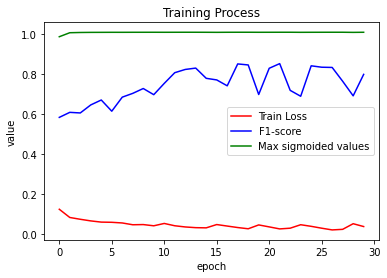

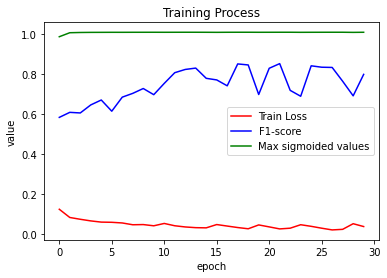

_____ Train Epoch 30 _____
_____ Train Epoch 30 _____
Epoch 30 | Batch 0 - Train loss = 0.053508 - Max mask value = 0.997211
Epoch 30 | Batch 0 - Train loss = 0.053508 - Max mask value = 0.997211
Epoch 30 | Batch 1 - Train loss = 0.024998 - Max mask value = 1.000000
Epoch 30 | Batch 1 - Train loss = 0.024998 - Max mask value = 1.000000
Epoch 30 | Batch 2 - Train loss = 0.035228 - Max mask value = 0.999995
Epoch 30 | Batch 2 - Train loss = 0.035228 - Max mask value = 0.999995
Epoch 30 | Batch 3 - Train loss = 0.020719 - Max mask value = 0.999734
Epoch 30 | Batch 3 - Train loss = 0.020719 - Max mask value = 0.999734
Epoch 30 | Batch 4 - Train loss = 0.020689 - Max mask value = 1.000000
Epoch 30 | Batch 4 - Train loss = 0.020689 - Max mask value = 1.000000
Epoch 30 | Batch 5 - Train loss = 0.024042 - Max mask value = 0.999989
Epoch 30 | Batch 5 - Train loss = 0.024042 - Max mask value = 0.999989
Epoch 30 | Batch 6 - Train loss = 0.020051 - Max mask value = 0.999960
Epoch 30 | Batch 6 - Tr

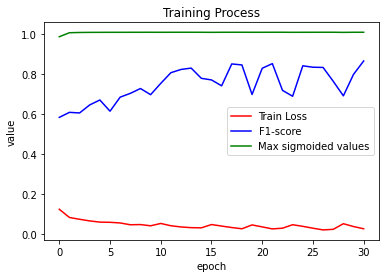

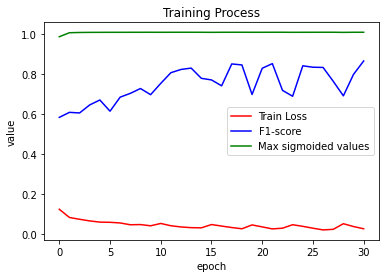

 - Saving Model...
 - Saving Model...
_____ Train Epoch 31 _____
_____ Train Epoch 31 _____
Epoch 31 | Batch 0 - Train loss = 0.012506 - Max mask value = 0.999997
Epoch 31 | Batch 0 - Train loss = 0.012506 - Max mask value = 0.999997
Epoch 31 | Batch 1 - Train loss = 0.015915 - Max mask value = 0.999997
Epoch 31 | Batch 1 - Train loss = 0.015915 - Max mask value = 0.999997
Epoch 31 | Batch 2 - Train loss = 0.026646 - Max mask value = 0.999999
Epoch 31 | Batch 2 - Train loss = 0.026646 - Max mask value = 0.999999
Epoch 31 | Batch 3 - Train loss = 0.014692 - Max mask value = 1.000000
Epoch 31 | Batch 3 - Train loss = 0.014692 - Max mask value = 1.000000
Epoch 31 | Batch 4 - Train loss = 0.018386 - Max mask value = 1.000000
Epoch 31 | Batch 4 - Train loss = 0.018386 - Max mask value = 1.000000
Epoch 31 | Batch 5 - Train loss = 0.018504 - Max mask value = 1.000000
Epoch 31 | Batch 5 - Train loss = 0.018504 - Max mask value = 1.000000
Epoch 31 | Batch 6 - Train loss = 0.023149 - Max mask va

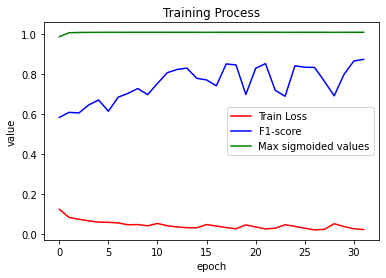

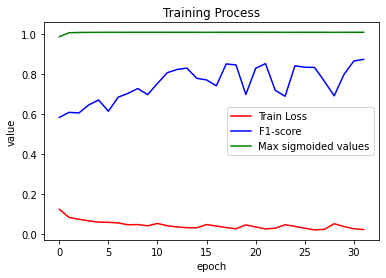

_____ Train Epoch 32 _____
_____ Train Epoch 32 _____
Epoch 32 | Batch 0 - Train loss = 0.018941 - Max mask value = 0.999941
Epoch 32 | Batch 0 - Train loss = 0.018941 - Max mask value = 0.999941
Epoch 32 | Batch 1 - Train loss = 0.017308 - Max mask value = 0.999999
Epoch 32 | Batch 1 - Train loss = 0.017308 - Max mask value = 0.999999
Epoch 32 | Batch 2 - Train loss = 0.019879 - Max mask value = 0.999999
Epoch 32 | Batch 2 - Train loss = 0.019879 - Max mask value = 0.999999
Epoch 32 | Batch 3 - Train loss = 0.014731 - Max mask value = 0.999999
Epoch 32 | Batch 3 - Train loss = 0.014731 - Max mask value = 0.999999
Epoch 32 | Batch 4 - Train loss = 0.026263 - Max mask value = 0.999997
Epoch 32 | Batch 4 - Train loss = 0.026263 - Max mask value = 0.999997
Epoch 32 | Batch 5 - Train loss = 0.029275 - Max mask value = 1.000000
Epoch 32 | Batch 5 - Train loss = 0.029275 - Max mask value = 1.000000
Epoch 32 | Batch 6 - Train loss = 0.013747 - Max mask value = 1.000000
Epoch 32 | Batch 6 - Tr

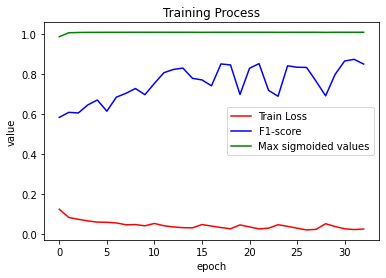

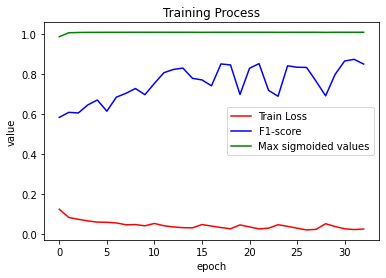

_____ Train Epoch 33 _____
_____ Train Epoch 33 _____
Epoch 33 | Batch 0 - Train loss = 0.020345 - Max mask value = 0.999933
Epoch 33 | Batch 0 - Train loss = 0.020345 - Max mask value = 0.999933
Epoch 33 | Batch 1 - Train loss = 0.015044 - Max mask value = 0.999963
Epoch 33 | Batch 1 - Train loss = 0.015044 - Max mask value = 0.999963
Epoch 33 | Batch 2 - Train loss = 0.015485 - Max mask value = 0.999938
Epoch 33 | Batch 2 - Train loss = 0.015485 - Max mask value = 0.999938
Epoch 33 | Batch 3 - Train loss = 0.015351 - Max mask value = 0.999956
Epoch 33 | Batch 3 - Train loss = 0.015351 - Max mask value = 0.999956
Epoch 33 | Batch 4 - Train loss = 0.026401 - Max mask value = 0.999996
Epoch 33 | Batch 4 - Train loss = 0.026401 - Max mask value = 0.999996
Epoch 33 | Batch 5 - Train loss = 0.027363 - Max mask value = 1.000000
Epoch 33 | Batch 5 - Train loss = 0.027363 - Max mask value = 1.000000
Epoch 33 | Batch 6 - Train loss = 0.033745 - Max mask value = 0.999970
Epoch 33 | Batch 6 - Tr

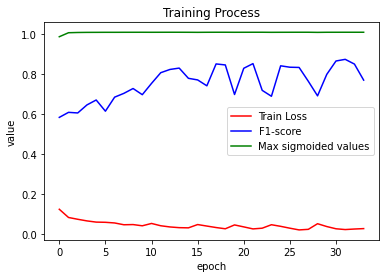

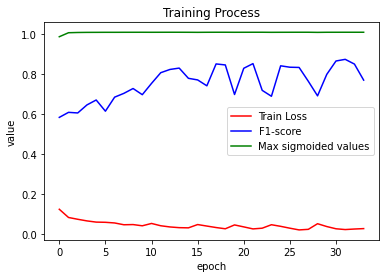

_____ Train Epoch 34 _____
_____ Train Epoch 34 _____
Epoch 34 | Batch 0 - Train loss = 0.041896 - Max mask value = 0.999591
Epoch 34 | Batch 0 - Train loss = 0.041896 - Max mask value = 0.999591
Epoch 34 | Batch 1 - Train loss = 0.012848 - Max mask value = 0.999991
Epoch 34 | Batch 1 - Train loss = 0.012848 - Max mask value = 0.999991
Epoch 34 | Batch 2 - Train loss = 0.029074 - Max mask value = 0.999851
Epoch 34 | Batch 2 - Train loss = 0.029074 - Max mask value = 0.999851
Epoch 34 | Batch 3 - Train loss = 0.024970 - Max mask value = 0.999969
Epoch 34 | Batch 3 - Train loss = 0.024970 - Max mask value = 0.999969
Epoch 34 | Batch 4 - Train loss = 0.030207 - Max mask value = 0.999961
Epoch 34 | Batch 4 - Train loss = 0.030207 - Max mask value = 0.999961
Epoch 34 | Batch 5 - Train loss = 0.030271 - Max mask value = 1.000000
Epoch 34 | Batch 5 - Train loss = 0.030271 - Max mask value = 1.000000
Epoch 34 | Batch 6 - Train loss = 0.070935 - Max mask value = 0.999763
Epoch 34 | Batch 6 - Tr

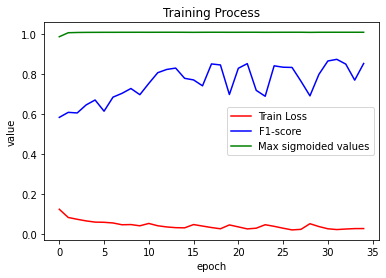

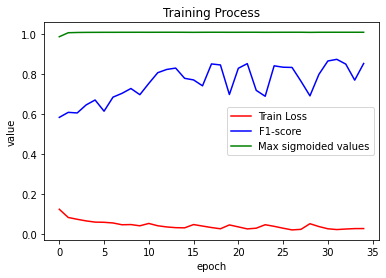

_____ Train Epoch 35 _____
_____ Train Epoch 35 _____
Epoch 35 | Batch 0 - Train loss = 0.018247 - Max mask value = 0.999998
Epoch 35 | Batch 0 - Train loss = 0.018247 - Max mask value = 0.999998
Epoch 35 | Batch 1 - Train loss = 0.027183 - Max mask value = 0.999998
Epoch 35 | Batch 1 - Train loss = 0.027183 - Max mask value = 0.999998
Epoch 35 | Batch 2 - Train loss = 0.012078 - Max mask value = 1.000000
Epoch 35 | Batch 2 - Train loss = 0.012078 - Max mask value = 1.000000
Epoch 35 | Batch 3 - Train loss = 0.024173 - Max mask value = 0.999957
Epoch 35 | Batch 3 - Train loss = 0.024173 - Max mask value = 0.999957
Epoch 35 | Batch 4 - Train loss = 0.033402 - Max mask value = 0.999984
Epoch 35 | Batch 4 - Train loss = 0.033402 - Max mask value = 0.999984
Epoch 35 | Batch 5 - Train loss = 0.032625 - Max mask value = 0.999910
Epoch 35 | Batch 5 - Train loss = 0.032625 - Max mask value = 0.999910
Epoch 35 | Batch 6 - Train loss = 0.012109 - Max mask value = 1.000000
Epoch 35 | Batch 6 - Tr

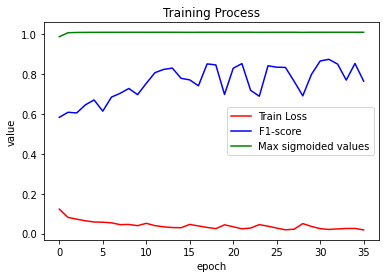

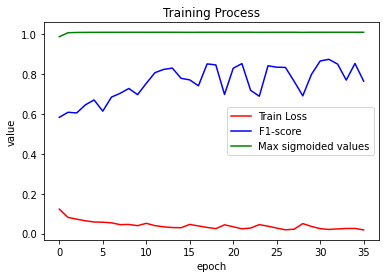

_____ Train Epoch 36 _____
_____ Train Epoch 36 _____
Epoch 36 | Batch 0 - Train loss = 0.030696 - Max mask value = 0.999985
Epoch 36 | Batch 0 - Train loss = 0.030696 - Max mask value = 0.999985
Epoch 36 | Batch 1 - Train loss = 0.023556 - Max mask value = 0.999860
Epoch 36 | Batch 1 - Train loss = 0.023556 - Max mask value = 0.999860
Epoch 36 | Batch 2 - Train loss = 0.028773 - Max mask value = 1.000000
Epoch 36 | Batch 2 - Train loss = 0.028773 - Max mask value = 1.000000
Epoch 36 | Batch 3 - Train loss = 0.070310 - Max mask value = 0.999979
Epoch 36 | Batch 3 - Train loss = 0.070310 - Max mask value = 0.999979
Epoch 36 | Batch 4 - Train loss = 0.018706 - Max mask value = 0.999930
Epoch 36 | Batch 4 - Train loss = 0.018706 - Max mask value = 0.999930
Epoch 36 | Batch 5 - Train loss = 0.019415 - Max mask value = 1.000000
Epoch 36 | Batch 5 - Train loss = 0.019415 - Max mask value = 1.000000
Epoch 36 | Batch 6 - Train loss = 0.019839 - Max mask value = 0.999999
Epoch 36 | Batch 6 - Tr

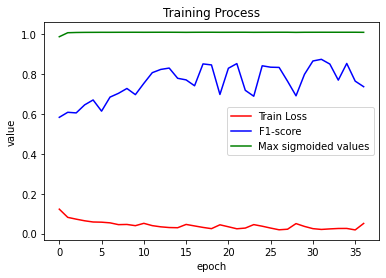

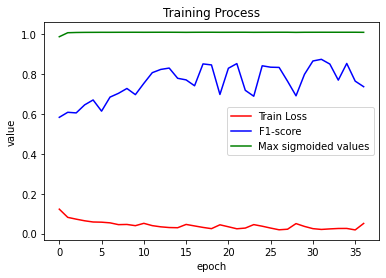

_____ Train Epoch 37 _____
_____ Train Epoch 37 _____
Epoch 37 | Batch 0 - Train loss = 0.070988 - Max mask value = 0.999957
Epoch 37 | Batch 0 - Train loss = 0.070988 - Max mask value = 0.999957
Epoch 37 | Batch 1 - Train loss = 0.044525 - Max mask value = 0.999996
Epoch 37 | Batch 1 - Train loss = 0.044525 - Max mask value = 0.999996
Epoch 37 | Batch 2 - Train loss = 0.053264 - Max mask value = 0.999897
Epoch 37 | Batch 2 - Train loss = 0.053264 - Max mask value = 0.999897
Epoch 37 | Batch 3 - Train loss = 0.095289 - Max mask value = 0.995401
Epoch 37 | Batch 3 - Train loss = 0.095289 - Max mask value = 0.995401
Epoch 37 | Batch 4 - Train loss = 0.040590 - Max mask value = 0.999447
Epoch 37 | Batch 4 - Train loss = 0.040590 - Max mask value = 0.999447
Epoch 37 | Batch 5 - Train loss = 0.065470 - Max mask value = 0.999944
Epoch 37 | Batch 5 - Train loss = 0.065470 - Max mask value = 0.999944
Epoch 37 | Batch 6 - Train loss = 0.019462 - Max mask value = 0.999999
Epoch 37 | Batch 6 - Tr

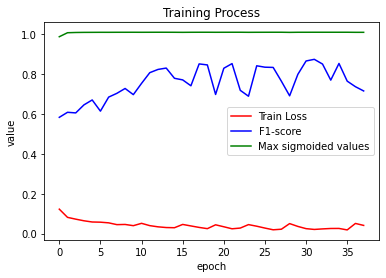

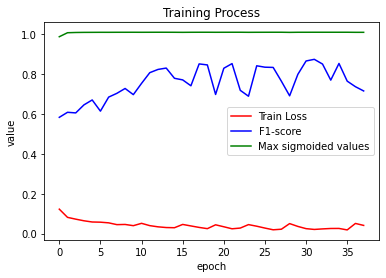

_____ Train Epoch 38 _____
_____ Train Epoch 38 _____
Epoch 38 | Batch 0 - Train loss = 0.034393 - Max mask value = 0.999032
Epoch 38 | Batch 0 - Train loss = 0.034393 - Max mask value = 0.999032
Epoch 38 | Batch 1 - Train loss = 0.063552 - Max mask value = 0.999740
Epoch 38 | Batch 1 - Train loss = 0.063552 - Max mask value = 0.999740
Epoch 38 | Batch 2 - Train loss = 0.101402 - Max mask value = 0.999988
Epoch 38 | Batch 2 - Train loss = 0.101402 - Max mask value = 0.999988
Epoch 38 | Batch 3 - Train loss = 0.060701 - Max mask value = 0.999626
Epoch 38 | Batch 3 - Train loss = 0.060701 - Max mask value = 0.999626
Epoch 38 | Batch 4 - Train loss = 0.029836 - Max mask value = 0.999828
Epoch 38 | Batch 4 - Train loss = 0.029836 - Max mask value = 0.999828
Epoch 38 | Batch 5 - Train loss = 0.026582 - Max mask value = 0.999811
Epoch 38 | Batch 5 - Train loss = 0.026582 - Max mask value = 0.999811
Epoch 38 | Batch 6 - Train loss = 0.049437 - Max mask value = 0.999995
Epoch 38 | Batch 6 - Tr

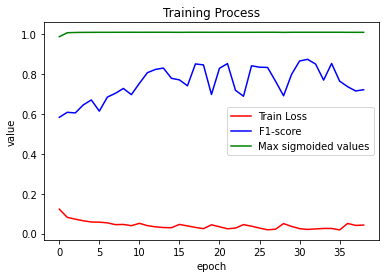

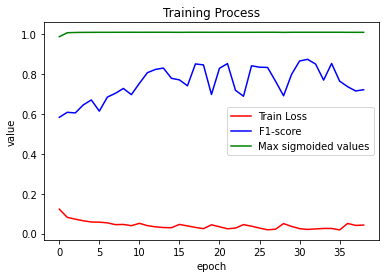

_____ Train Epoch 39 _____
_____ Train Epoch 39 _____
Epoch 39 | Batch 0 - Train loss = 0.018297 - Max mask value = 1.000000
Epoch 39 | Batch 0 - Train loss = 0.018297 - Max mask value = 1.000000
Epoch 39 | Batch 1 - Train loss = 0.046459 - Max mask value = 1.000000
Epoch 39 | Batch 1 - Train loss = 0.046459 - Max mask value = 1.000000
Epoch 39 | Batch 2 - Train loss = 0.026851 - Max mask value = 0.999979
Epoch 39 | Batch 2 - Train loss = 0.026851 - Max mask value = 0.999979
Epoch 39 | Batch 3 - Train loss = 0.046250 - Max mask value = 0.999906
Epoch 39 | Batch 3 - Train loss = 0.046250 - Max mask value = 0.999906
Epoch 39 | Batch 4 - Train loss = 0.043944 - Max mask value = 0.999650
Epoch 39 | Batch 4 - Train loss = 0.043944 - Max mask value = 0.999650
Epoch 39 | Batch 5 - Train loss = 0.047934 - Max mask value = 0.999910
Epoch 39 | Batch 5 - Train loss = 0.047934 - Max mask value = 0.999910
Epoch 39 | Batch 6 - Train loss = 0.020534 - Max mask value = 0.999985
Epoch 39 | Batch 6 - Tr

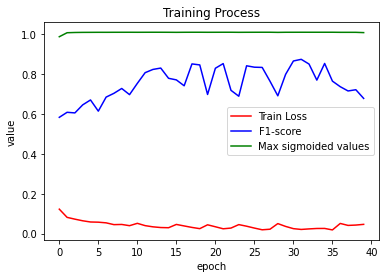

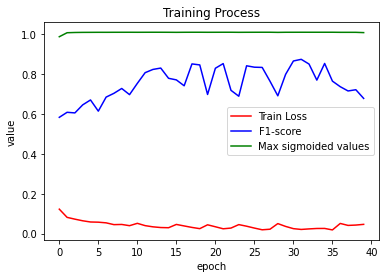

_____ Train Epoch 40 _____
_____ Train Epoch 40 _____
Epoch 40 | Batch 0 - Train loss = 0.047076 - Max mask value = 0.999999
Epoch 40 | Batch 0 - Train loss = 0.047076 - Max mask value = 0.999999
Epoch 40 | Batch 1 - Train loss = 0.124499 - Max mask value = 0.999964
Epoch 40 | Batch 1 - Train loss = 0.124499 - Max mask value = 0.999964
Epoch 40 | Batch 2 - Train loss = 0.049050 - Max mask value = 0.999980
Epoch 40 | Batch 2 - Train loss = 0.049050 - Max mask value = 0.999980
Epoch 40 | Batch 3 - Train loss = 0.054476 - Max mask value = 0.999986
Epoch 40 | Batch 3 - Train loss = 0.054476 - Max mask value = 0.999986
Epoch 40 | Batch 4 - Train loss = 0.110722 - Max mask value = 0.999947
Epoch 40 | Batch 4 - Train loss = 0.110722 - Max mask value = 0.999947
Epoch 40 | Batch 5 - Train loss = 0.083996 - Max mask value = 0.999981
Epoch 40 | Batch 5 - Train loss = 0.083996 - Max mask value = 0.999981
Epoch 40 | Batch 6 - Train loss = 0.090671 - Max mask value = 0.999462
Epoch 40 | Batch 6 - Tr

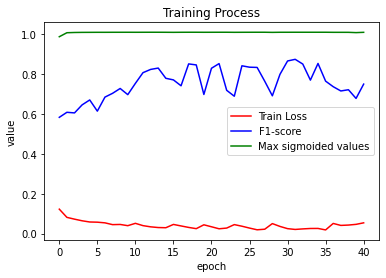

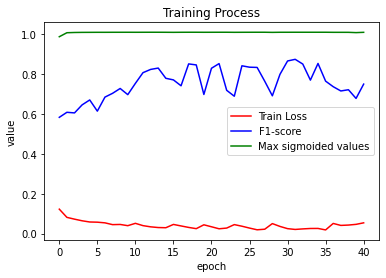

 - Saving Model...
 - Saving Model...
_____ Train Epoch 41 _____
_____ Train Epoch 41 _____
Epoch 41 | Batch 0 - Train loss = 0.057329 - Max mask value = 0.999376
Epoch 41 | Batch 0 - Train loss = 0.057329 - Max mask value = 0.999376
Epoch 41 | Batch 1 - Train loss = 0.025092 - Max mask value = 0.999958
Epoch 41 | Batch 1 - Train loss = 0.025092 - Max mask value = 0.999958
Epoch 41 | Batch 2 - Train loss = 0.013797 - Max mask value = 0.999863
Epoch 41 | Batch 2 - Train loss = 0.013797 - Max mask value = 0.999863
Epoch 41 | Batch 3 - Train loss = 0.032354 - Max mask value = 1.000000
Epoch 41 | Batch 3 - Train loss = 0.032354 - Max mask value = 1.000000
Epoch 41 | Batch 4 - Train loss = 0.062532 - Max mask value = 0.997035
Epoch 41 | Batch 4 - Train loss = 0.062532 - Max mask value = 0.997035
Epoch 41 | Batch 5 - Train loss = 0.032889 - Max mask value = 0.999991
Epoch 41 | Batch 5 - Train loss = 0.032889 - Max mask value = 0.999991
Epoch 41 | Batch 6 - Train loss = 0.020312 - Max mask va

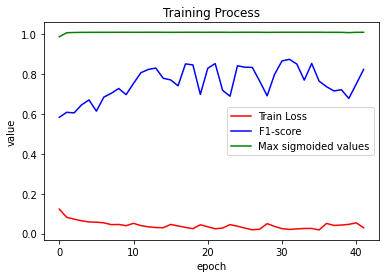

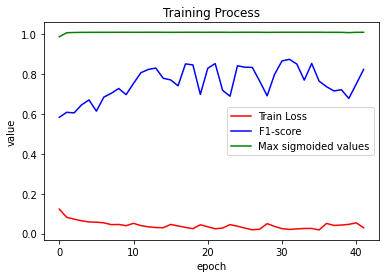

_____ Train Epoch 42 _____
_____ Train Epoch 42 _____
Epoch 42 | Batch 0 - Train loss = 0.026770 - Max mask value = 0.999923
Epoch 42 | Batch 0 - Train loss = 0.026770 - Max mask value = 0.999923
Epoch 42 | Batch 1 - Train loss = 0.070435 - Max mask value = 0.999929
Epoch 42 | Batch 1 - Train loss = 0.070435 - Max mask value = 0.999929
Epoch 42 | Batch 2 - Train loss = 0.027168 - Max mask value = 0.999943
Epoch 42 | Batch 2 - Train loss = 0.027168 - Max mask value = 0.999943
Epoch 42 | Batch 3 - Train loss = 0.069570 - Max mask value = 0.999984
Epoch 42 | Batch 3 - Train loss = 0.069570 - Max mask value = 0.999984
Epoch 42 | Batch 4 - Train loss = 0.048080 - Max mask value = 0.998509
Epoch 42 | Batch 4 - Train loss = 0.048080 - Max mask value = 0.998509
Epoch 42 | Batch 5 - Train loss = 0.024367 - Max mask value = 0.999984
Epoch 42 | Batch 5 - Train loss = 0.024367 - Max mask value = 0.999984
Epoch 42 | Batch 6 - Train loss = 0.082655 - Max mask value = 0.999996
Epoch 42 | Batch 6 - Tr

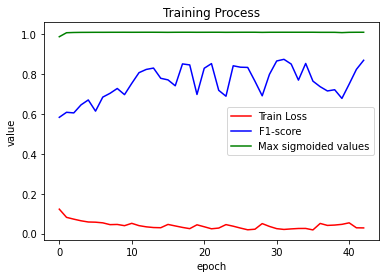

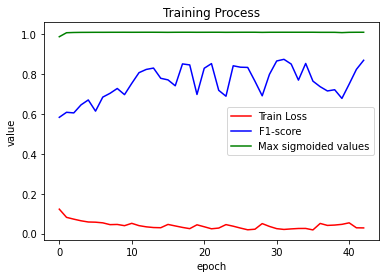

_____ Train Epoch 43 _____
_____ Train Epoch 43 _____
Epoch 43 | Batch 0 - Train loss = 0.015262 - Max mask value = 1.000000
Epoch 43 | Batch 0 - Train loss = 0.015262 - Max mask value = 1.000000
Epoch 43 | Batch 1 - Train loss = 0.024385 - Max mask value = 0.999992
Epoch 43 | Batch 1 - Train loss = 0.024385 - Max mask value = 0.999992
Epoch 43 | Batch 2 - Train loss = 0.023505 - Max mask value = 1.000000
Epoch 43 | Batch 2 - Train loss = 0.023505 - Max mask value = 1.000000
Epoch 43 | Batch 3 - Train loss = 0.018692 - Max mask value = 1.000000
Epoch 43 | Batch 3 - Train loss = 0.018692 - Max mask value = 1.000000
Epoch 43 | Batch 4 - Train loss = 0.022533 - Max mask value = 0.999997
Epoch 43 | Batch 4 - Train loss = 0.022533 - Max mask value = 0.999997
Epoch 43 | Batch 5 - Train loss = 0.011396 - Max mask value = 1.000000
Epoch 43 | Batch 5 - Train loss = 0.011396 - Max mask value = 1.000000
Epoch 43 | Batch 6 - Train loss = 0.013850 - Max mask value = 0.999999
Epoch 43 | Batch 6 - Tr

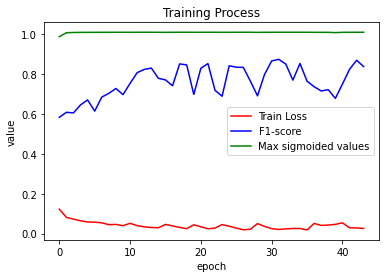

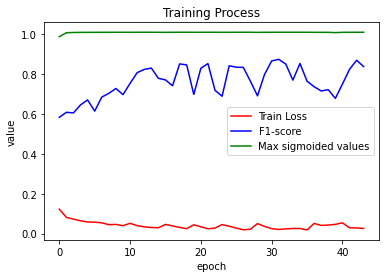

_____ Train Epoch 44 _____
_____ Train Epoch 44 _____
Epoch 44 | Batch 0 - Train loss = 0.016578 - Max mask value = 0.999829
Epoch 44 | Batch 0 - Train loss = 0.016578 - Max mask value = 0.999829
Epoch 44 | Batch 1 - Train loss = 0.047769 - Max mask value = 0.998382
Epoch 44 | Batch 1 - Train loss = 0.047769 - Max mask value = 0.998382
Epoch 44 | Batch 2 - Train loss = 0.037924 - Max mask value = 0.999972
Epoch 44 | Batch 2 - Train loss = 0.037924 - Max mask value = 0.999972
Epoch 44 | Batch 3 - Train loss = 0.017724 - Max mask value = 0.999978
Epoch 44 | Batch 3 - Train loss = 0.017724 - Max mask value = 0.999978
Epoch 44 | Batch 4 - Train loss = 0.037643 - Max mask value = 0.999924
Epoch 44 | Batch 4 - Train loss = 0.037643 - Max mask value = 0.999924
Epoch 44 | Batch 5 - Train loss = 0.017628 - Max mask value = 0.999935
Epoch 44 | Batch 5 - Train loss = 0.017628 - Max mask value = 0.999935
Epoch 44 | Batch 6 - Train loss = 0.050899 - Max mask value = 0.999495
Epoch 44 | Batch 6 - Tr

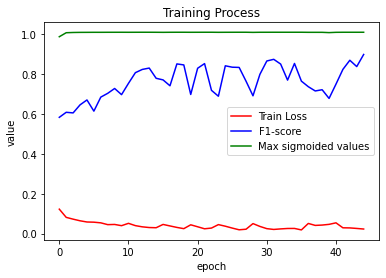

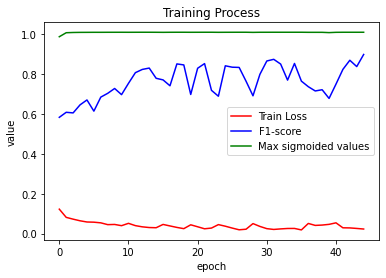

_____ Train Epoch 45 _____
_____ Train Epoch 45 _____
Epoch 45 | Batch 0 - Train loss = 0.006344 - Max mask value = 1.000000
Epoch 45 | Batch 0 - Train loss = 0.006344 - Max mask value = 1.000000
Epoch 45 | Batch 1 - Train loss = 0.025214 - Max mask value = 1.000000
Epoch 45 | Batch 1 - Train loss = 0.025214 - Max mask value = 1.000000
Epoch 45 | Batch 2 - Train loss = 0.013078 - Max mask value = 0.999998
Epoch 45 | Batch 2 - Train loss = 0.013078 - Max mask value = 0.999998
Epoch 45 | Batch 3 - Train loss = 0.028588 - Max mask value = 0.999980
Epoch 45 | Batch 3 - Train loss = 0.028588 - Max mask value = 0.999980
Epoch 45 | Batch 4 - Train loss = 0.025797 - Max mask value = 0.999999
Epoch 45 | Batch 4 - Train loss = 0.025797 - Max mask value = 0.999999
Epoch 45 | Batch 5 - Train loss = 0.011761 - Max mask value = 0.999997
Epoch 45 | Batch 5 - Train loss = 0.011761 - Max mask value = 0.999997
Epoch 45 | Batch 6 - Train loss = 0.028366 - Max mask value = 0.999974
Epoch 45 | Batch 6 - Tr

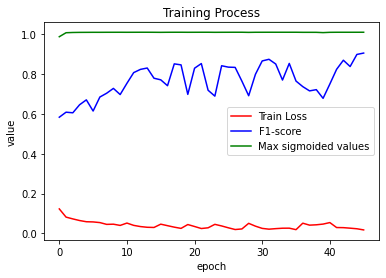

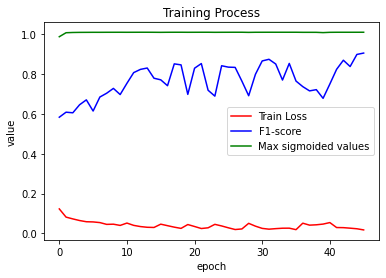

_____ Train Epoch 46 _____
_____ Train Epoch 46 _____
Epoch 46 | Batch 0 - Train loss = 0.010744 - Max mask value = 1.000000
Epoch 46 | Batch 0 - Train loss = 0.010744 - Max mask value = 1.000000
Epoch 46 | Batch 1 - Train loss = 0.020850 - Max mask value = 0.999999
Epoch 46 | Batch 1 - Train loss = 0.020850 - Max mask value = 0.999999
Epoch 46 | Batch 2 - Train loss = 0.018513 - Max mask value = 0.999998
Epoch 46 | Batch 2 - Train loss = 0.018513 - Max mask value = 0.999998
Epoch 46 | Batch 3 - Train loss = 0.018305 - Max mask value = 1.000000
Epoch 46 | Batch 3 - Train loss = 0.018305 - Max mask value = 1.000000
Epoch 46 | Batch 4 - Train loss = 0.006702 - Max mask value = 1.000000
Epoch 46 | Batch 4 - Train loss = 0.006702 - Max mask value = 1.000000
Epoch 46 | Batch 5 - Train loss = 0.009323 - Max mask value = 1.000000
Epoch 46 | Batch 5 - Train loss = 0.009323 - Max mask value = 1.000000
Epoch 46 | Batch 6 - Train loss = 0.013298 - Max mask value = 1.000000
Epoch 46 | Batch 6 - Tr

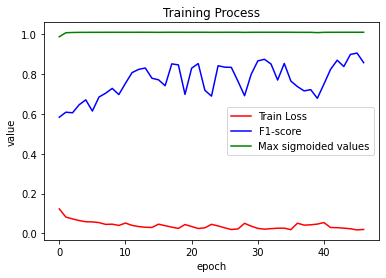

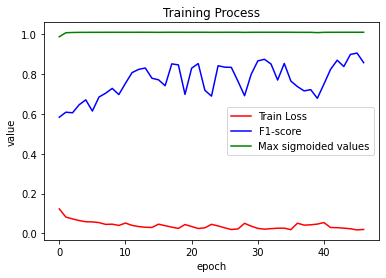

_____ Train Epoch 47 _____
_____ Train Epoch 47 _____
Epoch 47 | Batch 0 - Train loss = 0.056480 - Max mask value = 0.999976
Epoch 47 | Batch 0 - Train loss = 0.056480 - Max mask value = 0.999976
Epoch 47 | Batch 1 - Train loss = 0.030709 - Max mask value = 1.000000
Epoch 47 | Batch 1 - Train loss = 0.030709 - Max mask value = 1.000000
Epoch 47 | Batch 2 - Train loss = 0.031930 - Max mask value = 0.999997
Epoch 47 | Batch 2 - Train loss = 0.031930 - Max mask value = 0.999997
Epoch 47 | Batch 3 - Train loss = 0.026845 - Max mask value = 1.000000
Epoch 47 | Batch 3 - Train loss = 0.026845 - Max mask value = 1.000000
Epoch 47 | Batch 4 - Train loss = 0.053913 - Max mask value = 1.000000
Epoch 47 | Batch 4 - Train loss = 0.053913 - Max mask value = 1.000000
Epoch 47 | Batch 5 - Train loss = 0.018878 - Max mask value = 0.999889
Epoch 47 | Batch 5 - Train loss = 0.018878 - Max mask value = 0.999889
Epoch 47 | Batch 6 - Train loss = 0.017625 - Max mask value = 0.999973
Epoch 47 | Batch 6 - Tr

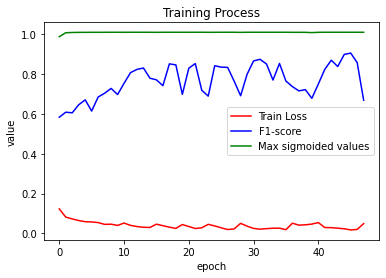

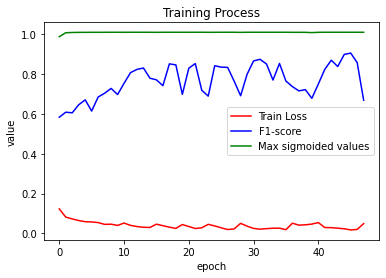

_____ Train Epoch 48 _____
_____ Train Epoch 48 _____
Epoch 48 | Batch 0 - Train loss = 0.059431 - Max mask value = 1.000000
Epoch 48 | Batch 0 - Train loss = 0.059431 - Max mask value = 1.000000
Epoch 48 | Batch 1 - Train loss = 0.046009 - Max mask value = 0.999871
Epoch 48 | Batch 1 - Train loss = 0.046009 - Max mask value = 0.999871
Epoch 48 | Batch 2 - Train loss = 0.069375 - Max mask value = 0.999591
Epoch 48 | Batch 2 - Train loss = 0.069375 - Max mask value = 0.999591
Epoch 48 | Batch 3 - Train loss = 0.067554 - Max mask value = 0.999872
Epoch 48 | Batch 3 - Train loss = 0.067554 - Max mask value = 0.999872
Epoch 48 | Batch 4 - Train loss = 0.038036 - Max mask value = 0.999942
Epoch 48 | Batch 4 - Train loss = 0.038036 - Max mask value = 0.999942
Epoch 48 | Batch 5 - Train loss = 0.024612 - Max mask value = 0.999978
Epoch 48 | Batch 5 - Train loss = 0.024612 - Max mask value = 0.999978
Epoch 48 | Batch 6 - Train loss = 0.026340 - Max mask value = 0.999920
Epoch 48 | Batch 6 - Tr

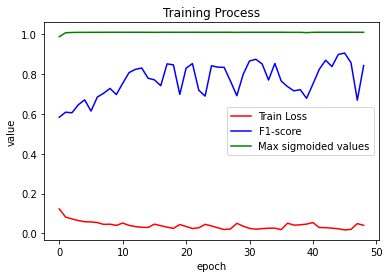

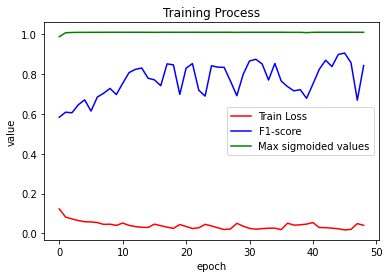

_____ Train Epoch 49 _____
_____ Train Epoch 49 _____
Epoch 49 | Batch 0 - Train loss = 0.028919 - Max mask value = 0.999898
Epoch 49 | Batch 0 - Train loss = 0.028919 - Max mask value = 0.999898
Epoch 49 | Batch 1 - Train loss = 0.035366 - Max mask value = 0.999949
Epoch 49 | Batch 1 - Train loss = 0.035366 - Max mask value = 0.999949
Epoch 49 | Batch 2 - Train loss = 0.037112 - Max mask value = 0.999998
Epoch 49 | Batch 2 - Train loss = 0.037112 - Max mask value = 0.999998
Epoch 49 | Batch 3 - Train loss = 0.014043 - Max mask value = 0.999946
Epoch 49 | Batch 3 - Train loss = 0.014043 - Max mask value = 0.999946
Epoch 49 | Batch 4 - Train loss = 0.048381 - Max mask value = 0.999998
Epoch 49 | Batch 4 - Train loss = 0.048381 - Max mask value = 0.999998
Epoch 49 | Batch 5 - Train loss = 0.040443 - Max mask value = 0.999954
Epoch 49 | Batch 5 - Train loss = 0.040443 - Max mask value = 0.999954
Epoch 49 | Batch 6 - Train loss = 0.021298 - Max mask value = 0.999999
Epoch 49 | Batch 6 - Tr

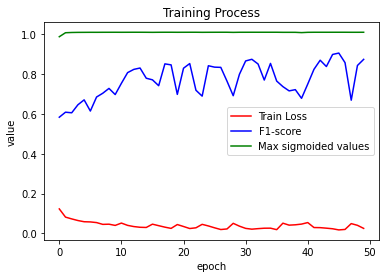

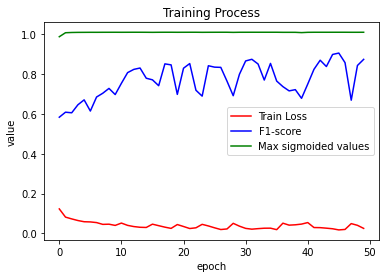

_____ Train Epoch 50 _____
_____ Train Epoch 50 _____
Epoch 50 | Batch 0 - Train loss = 0.028622 - Max mask value = 0.999532
Epoch 50 | Batch 0 - Train loss = 0.028622 - Max mask value = 0.999532
Epoch 50 | Batch 1 - Train loss = 0.023550 - Max mask value = 0.999961
Epoch 50 | Batch 1 - Train loss = 0.023550 - Max mask value = 0.999961
Epoch 50 | Batch 2 - Train loss = 0.023348 - Max mask value = 0.999994
Epoch 50 | Batch 2 - Train loss = 0.023348 - Max mask value = 0.999994
Epoch 50 | Batch 3 - Train loss = 0.018196 - Max mask value = 1.000000
Epoch 50 | Batch 3 - Train loss = 0.018196 - Max mask value = 1.000000
Epoch 50 | Batch 4 - Train loss = 0.009027 - Max mask value = 0.999999
Epoch 50 | Batch 4 - Train loss = 0.009027 - Max mask value = 0.999999
Epoch 50 | Batch 5 - Train loss = 0.015664 - Max mask value = 0.999996
Epoch 50 | Batch 5 - Train loss = 0.015664 - Max mask value = 0.999996
Epoch 50 | Batch 6 - Train loss = 0.020322 - Max mask value = 0.999999
Epoch 50 | Batch 6 - Tr

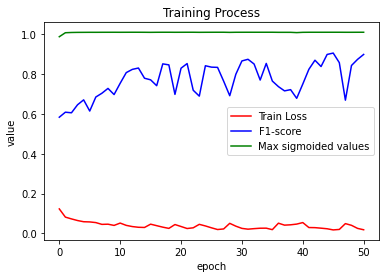

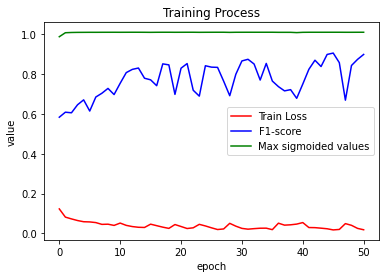

 - Saving Model...
 - Saving Model...
_____ Train Epoch 51 _____
_____ Train Epoch 51 _____
Epoch 51 | Batch 0 - Train loss = 0.010093 - Max mask value = 0.999993
Epoch 51 | Batch 0 - Train loss = 0.010093 - Max mask value = 0.999993
Epoch 51 | Batch 1 - Train loss = 0.029297 - Max mask value = 0.999262
Epoch 51 | Batch 1 - Train loss = 0.029297 - Max mask value = 0.999262
Epoch 51 | Batch 2 - Train loss = 0.013645 - Max mask value = 0.999999
Epoch 51 | Batch 2 - Train loss = 0.013645 - Max mask value = 0.999999
Epoch 51 | Batch 3 - Train loss = 0.015444 - Max mask value = 0.999999
Epoch 51 | Batch 3 - Train loss = 0.015444 - Max mask value = 0.999999
Epoch 51 | Batch 4 - Train loss = 0.023059 - Max mask value = 0.999999
Epoch 51 | Batch 4 - Train loss = 0.023059 - Max mask value = 0.999999
Epoch 51 | Batch 5 - Train loss = 0.024037 - Max mask value = 0.999919
Epoch 51 | Batch 5 - Train loss = 0.024037 - Max mask value = 0.999919
Epoch 51 | Batch 6 - Train loss = 0.009385 - Max mask va

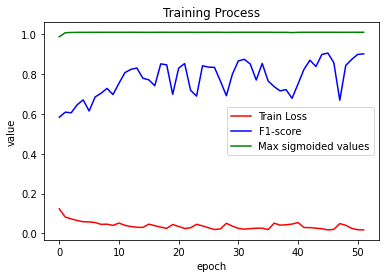

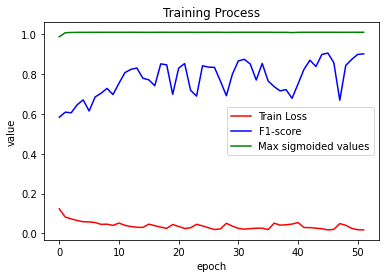

_____ Train Epoch 52 _____
_____ Train Epoch 52 _____
Epoch 52 | Batch 0 - Train loss = 0.012568 - Max mask value = 0.999994
Epoch 52 | Batch 0 - Train loss = 0.012568 - Max mask value = 0.999994
Epoch 52 | Batch 1 - Train loss = 0.019997 - Max mask value = 0.999998
Epoch 52 | Batch 1 - Train loss = 0.019997 - Max mask value = 0.999998
Epoch 52 | Batch 2 - Train loss = 0.012330 - Max mask value = 0.999998
Epoch 52 | Batch 2 - Train loss = 0.012330 - Max mask value = 0.999998
Epoch 52 | Batch 3 - Train loss = 0.025445 - Max mask value = 1.000000
Epoch 52 | Batch 3 - Train loss = 0.025445 - Max mask value = 1.000000
Epoch 52 | Batch 4 - Train loss = 0.009373 - Max mask value = 1.000000
Epoch 52 | Batch 4 - Train loss = 0.009373 - Max mask value = 1.000000
Epoch 52 | Batch 5 - Train loss = 0.016034 - Max mask value = 1.000000
Epoch 52 | Batch 5 - Train loss = 0.016034 - Max mask value = 1.000000
Epoch 52 | Batch 6 - Train loss = 0.012376 - Max mask value = 0.999882
Epoch 52 | Batch 6 - Tr

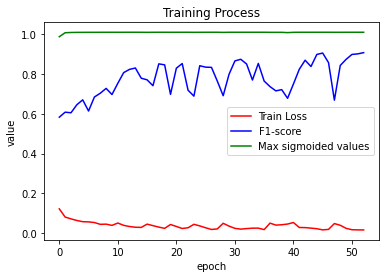

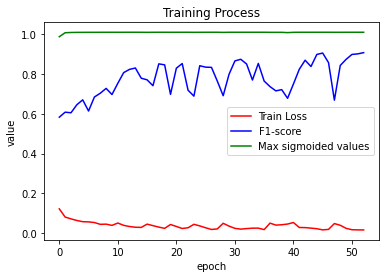

_____ Train Epoch 53 _____
_____ Train Epoch 53 _____
Epoch 53 | Batch 0 - Train loss = 0.039048 - Max mask value = 0.999976
Epoch 53 | Batch 0 - Train loss = 0.039048 - Max mask value = 0.999976
Epoch 53 | Batch 1 - Train loss = 0.019269 - Max mask value = 0.999962
Epoch 53 | Batch 1 - Train loss = 0.019269 - Max mask value = 0.999962
Epoch 53 | Batch 2 - Train loss = 0.020349 - Max mask value = 0.999999
Epoch 53 | Batch 2 - Train loss = 0.020349 - Max mask value = 0.999999
Epoch 53 | Batch 3 - Train loss = 0.026743 - Max mask value = 1.000000
Epoch 53 | Batch 3 - Train loss = 0.026743 - Max mask value = 1.000000
Epoch 53 | Batch 4 - Train loss = 0.017498 - Max mask value = 0.999978
Epoch 53 | Batch 4 - Train loss = 0.017498 - Max mask value = 0.999978
Epoch 53 | Batch 5 - Train loss = 0.010670 - Max mask value = 0.999995
Epoch 53 | Batch 5 - Train loss = 0.010670 - Max mask value = 0.999995
Epoch 53 | Batch 6 - Train loss = 0.020871 - Max mask value = 0.999983
Epoch 53 | Batch 6 - Tr

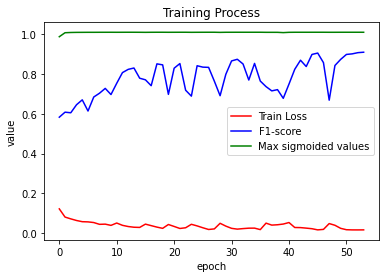

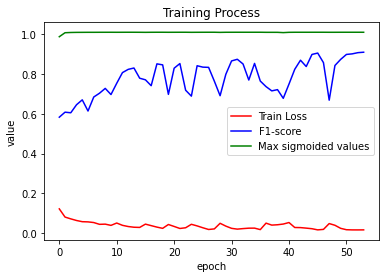

_____ Train Epoch 54 _____
_____ Train Epoch 54 _____
Epoch 54 | Batch 0 - Train loss = 0.013221 - Max mask value = 1.000000
Epoch 54 | Batch 0 - Train loss = 0.013221 - Max mask value = 1.000000
Epoch 54 | Batch 1 - Train loss = 0.020301 - Max mask value = 0.999882
Epoch 54 | Batch 1 - Train loss = 0.020301 - Max mask value = 0.999882
Epoch 54 | Batch 2 - Train loss = 0.024689 - Max mask value = 0.999992
Epoch 54 | Batch 2 - Train loss = 0.024689 - Max mask value = 0.999992
Epoch 54 | Batch 3 - Train loss = 0.023109 - Max mask value = 0.999808
Epoch 54 | Batch 3 - Train loss = 0.023109 - Max mask value = 0.999808
Epoch 54 | Batch 4 - Train loss = 0.016690 - Max mask value = 1.000000
Epoch 54 | Batch 4 - Train loss = 0.016690 - Max mask value = 1.000000
Epoch 54 | Batch 5 - Train loss = 0.013556 - Max mask value = 0.999995
Epoch 54 | Batch 5 - Train loss = 0.013556 - Max mask value = 0.999995
Epoch 54 | Batch 6 - Train loss = 0.021215 - Max mask value = 0.999917
Epoch 54 | Batch 6 - Tr

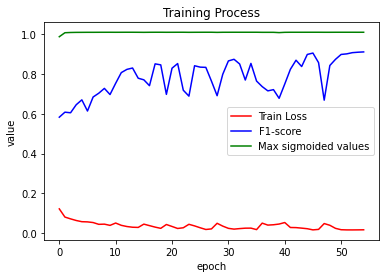

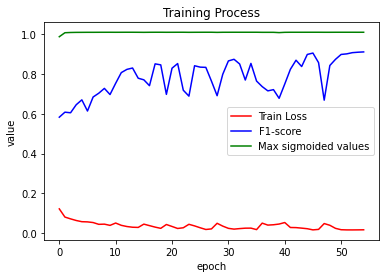

_____ Train Epoch 55 _____
_____ Train Epoch 55 _____
Epoch 55 | Batch 0 - Train loss = 0.014651 - Max mask value = 0.999988
Epoch 55 | Batch 0 - Train loss = 0.014651 - Max mask value = 0.999988
Epoch 55 | Batch 1 - Train loss = 0.016971 - Max mask value = 0.999991
Epoch 55 | Batch 1 - Train loss = 0.016971 - Max mask value = 0.999991
Epoch 55 | Batch 2 - Train loss = 0.025392 - Max mask value = 0.999999
Epoch 55 | Batch 2 - Train loss = 0.025392 - Max mask value = 0.999999
Epoch 55 | Batch 3 - Train loss = 0.021299 - Max mask value = 0.999979
Epoch 55 | Batch 3 - Train loss = 0.021299 - Max mask value = 0.999979
Epoch 55 | Batch 4 - Train loss = 0.014068 - Max mask value = 0.999990
Epoch 55 | Batch 4 - Train loss = 0.014068 - Max mask value = 0.999990
Epoch 55 | Batch 5 - Train loss = 0.026067 - Max mask value = 1.000000
Epoch 55 | Batch 5 - Train loss = 0.026067 - Max mask value = 1.000000
Epoch 55 | Batch 6 - Train loss = 0.019666 - Max mask value = 0.999979
Epoch 55 | Batch 6 - Tr

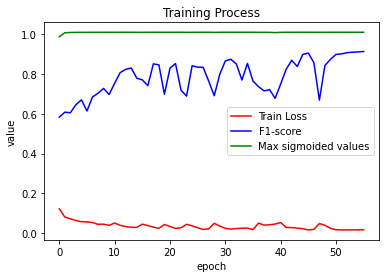

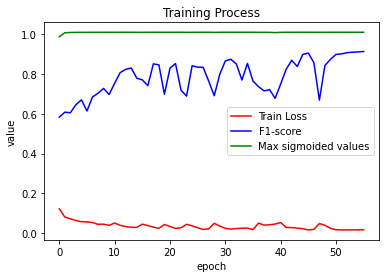

_____ Train Epoch 56 _____
_____ Train Epoch 56 _____
Epoch 56 | Batch 0 - Train loss = 0.012944 - Max mask value = 0.999982
Epoch 56 | Batch 0 - Train loss = 0.012944 - Max mask value = 0.999982
Epoch 56 | Batch 1 - Train loss = 0.019202 - Max mask value = 0.999856
Epoch 56 | Batch 1 - Train loss = 0.019202 - Max mask value = 0.999856
Epoch 56 | Batch 2 - Train loss = 0.015504 - Max mask value = 0.999988
Epoch 56 | Batch 2 - Train loss = 0.015504 - Max mask value = 0.999988
Epoch 56 | Batch 3 - Train loss = 0.021406 - Max mask value = 0.999867
Epoch 56 | Batch 3 - Train loss = 0.021406 - Max mask value = 0.999867
Epoch 56 | Batch 4 - Train loss = 0.022371 - Max mask value = 0.999907
Epoch 56 | Batch 4 - Train loss = 0.022371 - Max mask value = 0.999907
Epoch 56 | Batch 5 - Train loss = 0.016520 - Max mask value = 0.999776
Epoch 56 | Batch 5 - Train loss = 0.016520 - Max mask value = 0.999776
Epoch 56 | Batch 6 - Train loss = 0.030752 - Max mask value = 0.999990
Epoch 56 | Batch 6 - Tr

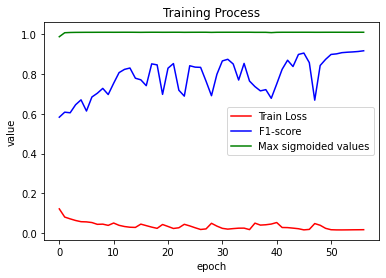

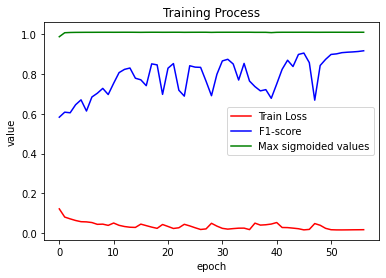

_____ Train Epoch 57 _____
_____ Train Epoch 57 _____
Epoch 57 | Batch 0 - Train loss = 0.017770 - Max mask value = 1.000000
Epoch 57 | Batch 0 - Train loss = 0.017770 - Max mask value = 1.000000
Epoch 57 | Batch 1 - Train loss = 0.017628 - Max mask value = 0.999993
Epoch 57 | Batch 1 - Train loss = 0.017628 - Max mask value = 0.999993
Epoch 57 | Batch 2 - Train loss = 0.018929 - Max mask value = 0.999933
Epoch 57 | Batch 2 - Train loss = 0.018929 - Max mask value = 0.999933
Epoch 57 | Batch 3 - Train loss = 0.009579 - Max mask value = 0.999793
Epoch 57 | Batch 3 - Train loss = 0.009579 - Max mask value = 0.999793
Epoch 57 | Batch 4 - Train loss = 0.017911 - Max mask value = 0.999930
Epoch 57 | Batch 4 - Train loss = 0.017911 - Max mask value = 0.999930
Epoch 57 | Batch 5 - Train loss = 0.020118 - Max mask value = 0.999977
Epoch 57 | Batch 5 - Train loss = 0.020118 - Max mask value = 0.999977
Epoch 57 | Batch 6 - Train loss = 0.016689 - Max mask value = 0.999999
Epoch 57 | Batch 6 - Tr

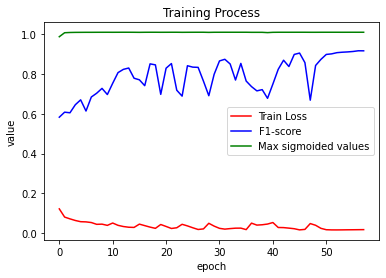

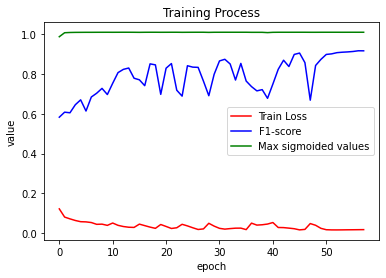

_____ Train Epoch 58 _____
_____ Train Epoch 58 _____
Epoch 58 | Batch 0 - Train loss = 0.022291 - Max mask value = 0.999991
Epoch 58 | Batch 0 - Train loss = 0.022291 - Max mask value = 0.999991
Epoch 58 | Batch 1 - Train loss = 0.014734 - Max mask value = 0.999934
Epoch 58 | Batch 1 - Train loss = 0.014734 - Max mask value = 0.999934
Epoch 58 | Batch 2 - Train loss = 0.012657 - Max mask value = 0.999993
Epoch 58 | Batch 2 - Train loss = 0.012657 - Max mask value = 0.999993
Epoch 58 | Batch 3 - Train loss = 0.022125 - Max mask value = 0.999963
Epoch 58 | Batch 3 - Train loss = 0.022125 - Max mask value = 0.999963
Epoch 58 | Batch 4 - Train loss = 0.017997 - Max mask value = 1.000000
Epoch 58 | Batch 4 - Train loss = 0.017997 - Max mask value = 1.000000
Epoch 58 | Batch 5 - Train loss = 0.023687 - Max mask value = 0.999729
Epoch 58 | Batch 5 - Train loss = 0.023687 - Max mask value = 0.999729
Epoch 58 | Batch 6 - Train loss = 0.014889 - Max mask value = 0.999993
Epoch 58 | Batch 6 - Tr

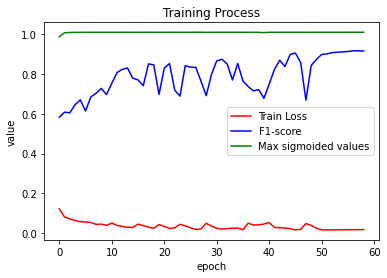

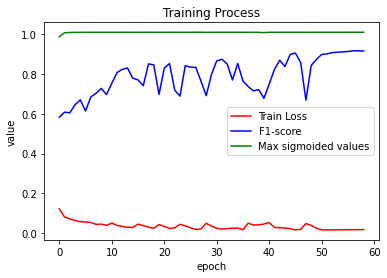

_____ Train Epoch 59 _____
_____ Train Epoch 59 _____
Epoch 59 | Batch 0 - Train loss = 0.022550 - Max mask value = 0.999673
Epoch 59 | Batch 0 - Train loss = 0.022550 - Max mask value = 0.999673
Epoch 59 | Batch 1 - Train loss = 0.012326 - Max mask value = 0.999995
Epoch 59 | Batch 1 - Train loss = 0.012326 - Max mask value = 0.999995
Epoch 59 | Batch 2 - Train loss = 0.018303 - Max mask value = 0.999929
Epoch 59 | Batch 2 - Train loss = 0.018303 - Max mask value = 0.999929
Epoch 59 | Batch 3 - Train loss = 0.015377 - Max mask value = 0.999995
Epoch 59 | Batch 3 - Train loss = 0.015377 - Max mask value = 0.999995
Epoch 59 | Batch 4 - Train loss = 0.012929 - Max mask value = 0.999832
Epoch 59 | Batch 4 - Train loss = 0.012929 - Max mask value = 0.999832
Epoch 59 | Batch 5 - Train loss = 0.011518 - Max mask value = 0.999941
Epoch 59 | Batch 5 - Train loss = 0.011518 - Max mask value = 0.999941
Epoch 59 | Batch 6 - Train loss = 0.028331 - Max mask value = 0.999914
Epoch 59 | Batch 6 - Tr

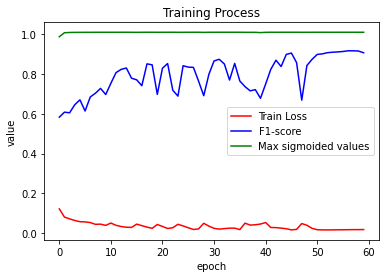

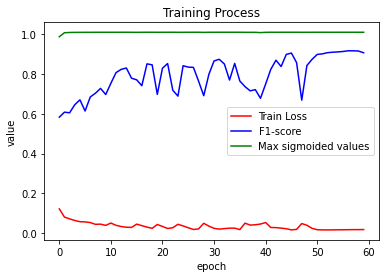

_____ Train Epoch 60 _____
_____ Train Epoch 60 _____
Epoch 60 | Batch 0 - Train loss = 0.027035 - Max mask value = 0.999877
Epoch 60 | Batch 0 - Train loss = 0.027035 - Max mask value = 0.999877
Epoch 60 | Batch 1 - Train loss = 0.014519 - Max mask value = 0.999947
Epoch 60 | Batch 1 - Train loss = 0.014519 - Max mask value = 0.999947
Epoch 60 | Batch 2 - Train loss = 0.011766 - Max mask value = 0.999987
Epoch 60 | Batch 2 - Train loss = 0.011766 - Max mask value = 0.999987
Epoch 60 | Batch 3 - Train loss = 0.014561 - Max mask value = 0.999988
Epoch 60 | Batch 3 - Train loss = 0.014561 - Max mask value = 0.999988
Epoch 60 | Batch 4 - Train loss = 0.012186 - Max mask value = 0.999958
Epoch 60 | Batch 4 - Train loss = 0.012186 - Max mask value = 0.999958
Epoch 60 | Batch 5 - Train loss = 0.014470 - Max mask value = 0.999995
Epoch 60 | Batch 5 - Train loss = 0.014470 - Max mask value = 0.999995
Epoch 60 | Batch 6 - Train loss = 0.023151 - Max mask value = 0.999835
Epoch 60 | Batch 6 - Tr

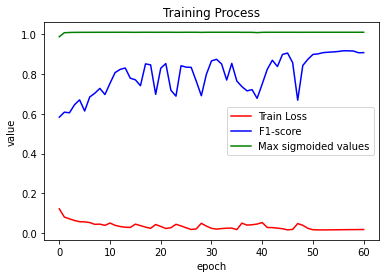

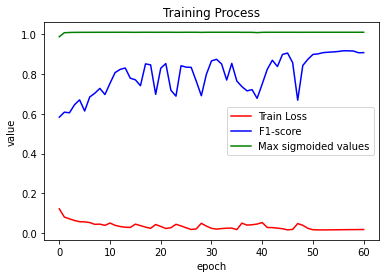

 - Saving Model...
 - Saving Model...
_____ Train Epoch 61 _____
_____ Train Epoch 61 _____
Epoch 61 | Batch 0 - Train loss = 0.015715 - Max mask value = 0.999905
Epoch 61 | Batch 0 - Train loss = 0.015715 - Max mask value = 0.999905
Epoch 61 | Batch 1 - Train loss = 0.016391 - Max mask value = 0.999997
Epoch 61 | Batch 1 - Train loss = 0.016391 - Max mask value = 0.999997
Epoch 61 | Batch 2 - Train loss = 0.023067 - Max mask value = 0.999968
Epoch 61 | Batch 2 - Train loss = 0.023067 - Max mask value = 0.999968
Epoch 61 | Batch 3 - Train loss = 0.023660 - Max mask value = 0.999999
Epoch 61 | Batch 3 - Train loss = 0.023660 - Max mask value = 0.999999
Epoch 61 | Batch 4 - Train loss = 0.022814 - Max mask value = 0.999980
Epoch 61 | Batch 4 - Train loss = 0.022814 - Max mask value = 0.999980
Epoch 61 | Batch 5 - Train loss = 0.015546 - Max mask value = 0.999992
Epoch 61 | Batch 5 - Train loss = 0.015546 - Max mask value = 0.999992
Epoch 61 | Batch 6 - Train loss = 0.021046 - Max mask va

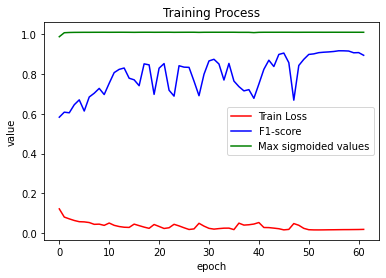

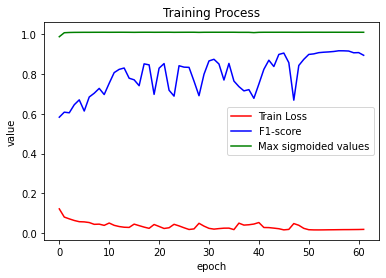

_____ Train Epoch 62 _____
_____ Train Epoch 62 _____
Epoch 62 | Batch 0 - Train loss = 0.018188 - Max mask value = 1.000000
Epoch 62 | Batch 0 - Train loss = 0.018188 - Max mask value = 1.000000
Epoch 62 | Batch 1 - Train loss = 0.013365 - Max mask value = 0.999974
Epoch 62 | Batch 1 - Train loss = 0.013365 - Max mask value = 0.999974
Epoch 62 | Batch 2 - Train loss = 0.015111 - Max mask value = 0.999993
Epoch 62 | Batch 2 - Train loss = 0.015111 - Max mask value = 0.999993
Epoch 62 | Batch 3 - Train loss = 0.018651 - Max mask value = 0.999999
Epoch 62 | Batch 3 - Train loss = 0.018651 - Max mask value = 0.999999
Epoch 62 | Batch 4 - Train loss = 0.015276 - Max mask value = 0.999975
Epoch 62 | Batch 4 - Train loss = 0.015276 - Max mask value = 0.999975
Epoch 62 | Batch 5 - Train loss = 0.021229 - Max mask value = 0.999993
Epoch 62 | Batch 5 - Train loss = 0.021229 - Max mask value = 0.999993
Epoch 62 | Batch 6 - Train loss = 0.024848 - Max mask value = 0.998915
Epoch 62 | Batch 6 - Tr

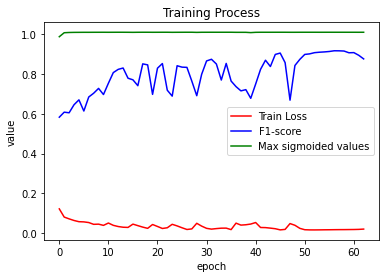

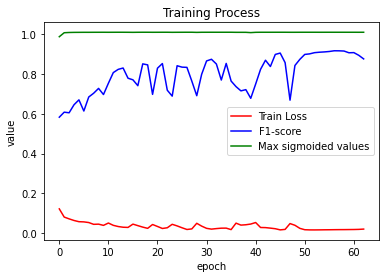

_____ Train Epoch 63 _____
_____ Train Epoch 63 _____
Epoch 63 | Batch 0 - Train loss = 0.011338 - Max mask value = 0.999974
Epoch 63 | Batch 0 - Train loss = 0.011338 - Max mask value = 0.999974
Epoch 63 | Batch 1 - Train loss = 0.030778 - Max mask value = 1.000000
Epoch 63 | Batch 1 - Train loss = 0.030778 - Max mask value = 1.000000
Epoch 63 | Batch 2 - Train loss = 0.026701 - Max mask value = 0.999994
Epoch 63 | Batch 2 - Train loss = 0.026701 - Max mask value = 0.999994
Epoch 63 | Batch 3 - Train loss = 0.018202 - Max mask value = 0.999879
Epoch 63 | Batch 3 - Train loss = 0.018202 - Max mask value = 0.999879
Epoch 63 | Batch 4 - Train loss = 0.021747 - Max mask value = 0.999948
Epoch 63 | Batch 4 - Train loss = 0.021747 - Max mask value = 0.999948
Epoch 63 | Batch 5 - Train loss = 0.020907 - Max mask value = 0.999999
Epoch 63 | Batch 5 - Train loss = 0.020907 - Max mask value = 0.999999
Epoch 63 | Batch 6 - Train loss = 0.025524 - Max mask value = 0.999749
Epoch 63 | Batch 6 - Tr

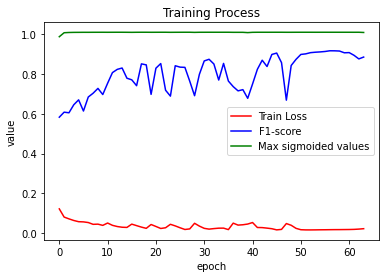

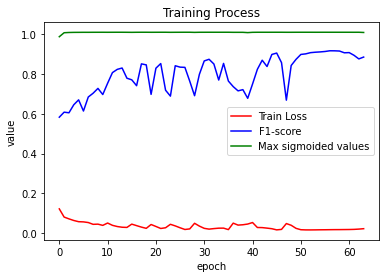

_____ Train Epoch 64 _____
_____ Train Epoch 64 _____
Epoch 64 | Batch 0 - Train loss = 0.023851 - Max mask value = 0.999999
Epoch 64 | Batch 0 - Train loss = 0.023851 - Max mask value = 0.999999
Epoch 64 | Batch 1 - Train loss = 0.017425 - Max mask value = 0.999885
Epoch 64 | Batch 1 - Train loss = 0.017425 - Max mask value = 0.999885
Epoch 64 | Batch 2 - Train loss = 0.023179 - Max mask value = 0.999867
Epoch 64 | Batch 2 - Train loss = 0.023179 - Max mask value = 0.999867
Epoch 64 | Batch 3 - Train loss = 0.081537 - Max mask value = 0.999923
Epoch 64 | Batch 3 - Train loss = 0.081537 - Max mask value = 0.999923
Epoch 64 | Batch 4 - Train loss = 0.069413 - Max mask value = 0.999915
Epoch 64 | Batch 4 - Train loss = 0.069413 - Max mask value = 0.999915
Epoch 64 | Batch 5 - Train loss = 0.045224 - Max mask value = 0.999950
Epoch 64 | Batch 5 - Train loss = 0.045224 - Max mask value = 0.999950
Epoch 64 | Batch 6 - Train loss = 0.026744 - Max mask value = 0.999649
Epoch 64 | Batch 6 - Tr

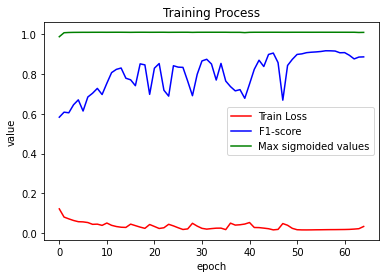

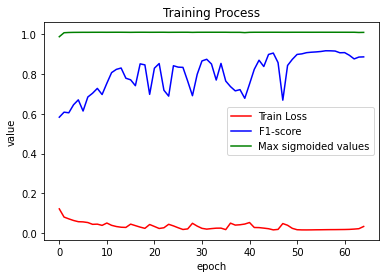

_____ Train Epoch 65 _____
_____ Train Epoch 65 _____
Epoch 65 | Batch 0 - Train loss = 0.020182 - Max mask value = 0.999982
Epoch 65 | Batch 0 - Train loss = 0.020182 - Max mask value = 0.999982
Epoch 65 | Batch 1 - Train loss = 0.022437 - Max mask value = 0.999314
Epoch 65 | Batch 1 - Train loss = 0.022437 - Max mask value = 0.999314
Epoch 65 | Batch 2 - Train loss = 0.018138 - Max mask value = 0.999704
Epoch 65 | Batch 2 - Train loss = 0.018138 - Max mask value = 0.999704
Epoch 65 | Batch 3 - Train loss = 0.024410 - Max mask value = 0.998321
Epoch 65 | Batch 3 - Train loss = 0.024410 - Max mask value = 0.998321
Epoch 65 | Batch 4 - Train loss = 0.033918 - Max mask value = 0.999557
Epoch 65 | Batch 4 - Train loss = 0.033918 - Max mask value = 0.999557
Epoch 65 | Batch 5 - Train loss = 0.021950 - Max mask value = 0.999909
Epoch 65 | Batch 5 - Train loss = 0.021950 - Max mask value = 0.999909
Epoch 65 | Batch 6 - Train loss = 0.020128 - Max mask value = 0.999985
Epoch 65 | Batch 6 - Tr

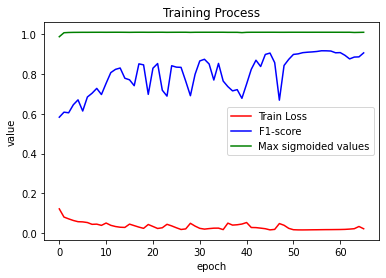

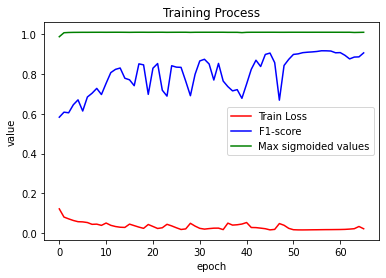

_____ Train Epoch 66 _____
_____ Train Epoch 66 _____
Epoch 66 | Batch 0 - Train loss = 0.011330 - Max mask value = 0.999999
Epoch 66 | Batch 0 - Train loss = 0.011330 - Max mask value = 0.999999
Epoch 66 | Batch 1 - Train loss = 0.026926 - Max mask value = 0.999953
Epoch 66 | Batch 1 - Train loss = 0.026926 - Max mask value = 0.999953
Epoch 66 | Batch 2 - Train loss = 0.018756 - Max mask value = 0.999762
Epoch 66 | Batch 2 - Train loss = 0.018756 - Max mask value = 0.999762
Epoch 66 | Batch 3 - Train loss = 0.011586 - Max mask value = 0.999931
Epoch 66 | Batch 3 - Train loss = 0.011586 - Max mask value = 0.999931
Epoch 66 | Batch 4 - Train loss = 0.018123 - Max mask value = 0.999972
Epoch 66 | Batch 4 - Train loss = 0.018123 - Max mask value = 0.999972
Epoch 66 | Batch 5 - Train loss = 0.016251 - Max mask value = 0.999931
Epoch 66 | Batch 5 - Train loss = 0.016251 - Max mask value = 0.999931
Epoch 66 | Batch 6 - Train loss = 0.011516 - Max mask value = 0.999998
Epoch 66 | Batch 6 - Tr

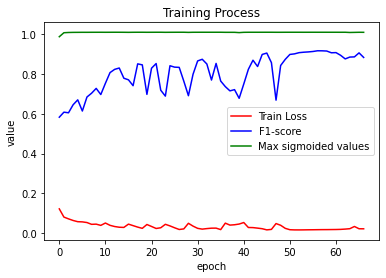

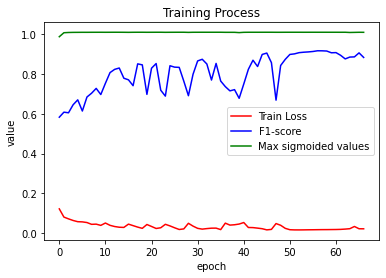

_____ Train Epoch 67 _____
_____ Train Epoch 67 _____
Epoch 67 | Batch 0 - Train loss = 0.019434 - Max mask value = 0.999968
Epoch 67 | Batch 0 - Train loss = 0.019434 - Max mask value = 0.999968
Epoch 67 | Batch 1 - Train loss = 0.028961 - Max mask value = 0.999914
Epoch 67 | Batch 1 - Train loss = 0.028961 - Max mask value = 0.999914
Epoch 67 | Batch 2 - Train loss = 0.018458 - Max mask value = 0.999993
Epoch 67 | Batch 2 - Train loss = 0.018458 - Max mask value = 0.999993
Epoch 67 | Batch 3 - Train loss = 0.026030 - Max mask value = 0.999996
Epoch 67 | Batch 3 - Train loss = 0.026030 - Max mask value = 0.999996
Epoch 67 | Batch 4 - Train loss = 0.035886 - Max mask value = 0.999943
Epoch 67 | Batch 4 - Train loss = 0.035886 - Max mask value = 0.999943
Epoch 67 | Batch 5 - Train loss = 0.040261 - Max mask value = 0.999982
Epoch 67 | Batch 5 - Train loss = 0.040261 - Max mask value = 0.999982
Epoch 67 | Batch 6 - Train loss = 0.027033 - Max mask value = 0.999983
Epoch 67 | Batch 6 - Tr

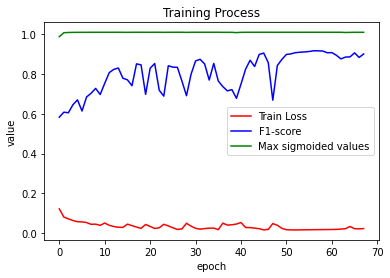

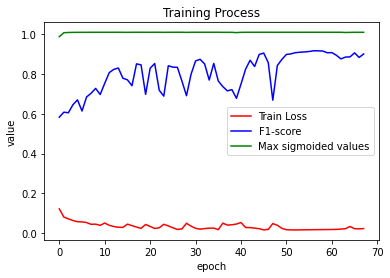

_____ Train Epoch 68 _____
_____ Train Epoch 68 _____
Epoch 68 | Batch 0 - Train loss = 0.020645 - Max mask value = 0.999858
Epoch 68 | Batch 0 - Train loss = 0.020645 - Max mask value = 0.999858
Epoch 68 | Batch 1 - Train loss = 0.021249 - Max mask value = 0.999233
Epoch 68 | Batch 1 - Train loss = 0.021249 - Max mask value = 0.999233
Epoch 68 | Batch 2 - Train loss = 0.028558 - Max mask value = 0.999994
Epoch 68 | Batch 2 - Train loss = 0.028558 - Max mask value = 0.999994
Epoch 68 | Batch 3 - Train loss = 0.020827 - Max mask value = 0.999937
Epoch 68 | Batch 3 - Train loss = 0.020827 - Max mask value = 0.999937
Epoch 68 | Batch 4 - Train loss = 0.029337 - Max mask value = 0.999998
Epoch 68 | Batch 4 - Train loss = 0.029337 - Max mask value = 0.999998
Epoch 68 | Batch 5 - Train loss = 0.019027 - Max mask value = 0.999779
Epoch 68 | Batch 5 - Train loss = 0.019027 - Max mask value = 0.999779
Epoch 68 | Batch 6 - Train loss = 0.019237 - Max mask value = 0.999999
Epoch 68 | Batch 6 - Tr

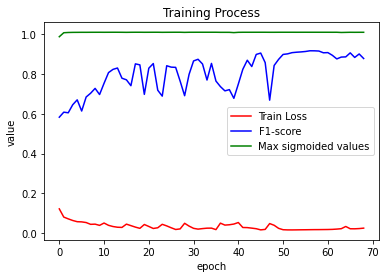

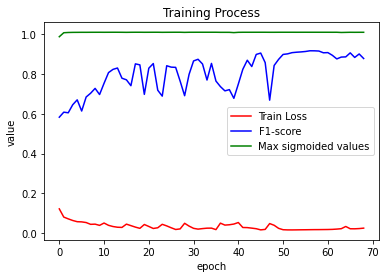

_____ Train Epoch 69 _____
_____ Train Epoch 69 _____
Epoch 69 | Batch 0 - Train loss = 0.059228 - Max mask value = 0.999911
Epoch 69 | Batch 0 - Train loss = 0.059228 - Max mask value = 0.999911
Epoch 69 | Batch 1 - Train loss = 0.031502 - Max mask value = 0.999914
Epoch 69 | Batch 1 - Train loss = 0.031502 - Max mask value = 0.999914
Epoch 69 | Batch 2 - Train loss = 0.050683 - Max mask value = 0.999990
Epoch 69 | Batch 2 - Train loss = 0.050683 - Max mask value = 0.999990
Epoch 69 | Batch 3 - Train loss = 0.043050 - Max mask value = 0.999910
Epoch 69 | Batch 3 - Train loss = 0.043050 - Max mask value = 0.999910
Epoch 69 | Batch 4 - Train loss = 0.056206 - Max mask value = 0.998896
Epoch 69 | Batch 4 - Train loss = 0.056206 - Max mask value = 0.998896
Epoch 69 | Batch 5 - Train loss = 0.024631 - Max mask value = 0.999991
Epoch 69 | Batch 5 - Train loss = 0.024631 - Max mask value = 0.999991
Epoch 69 | Batch 6 - Train loss = 0.029446 - Max mask value = 0.999980
Epoch 69 | Batch 6 - Tr

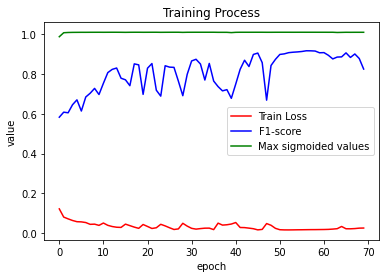

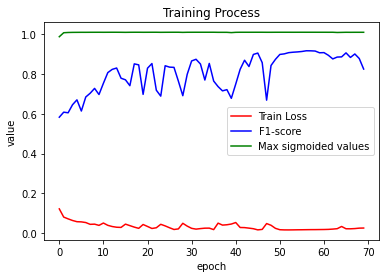

_____ Train Epoch 70 _____
_____ Train Epoch 70 _____
Epoch 70 | Batch 0 - Train loss = 0.021227 - Max mask value = 0.999977
Epoch 70 | Batch 0 - Train loss = 0.021227 - Max mask value = 0.999977
Epoch 70 | Batch 1 - Train loss = 0.016896 - Max mask value = 0.999906
Epoch 70 | Batch 1 - Train loss = 0.016896 - Max mask value = 0.999906
Epoch 70 | Batch 2 - Train loss = 0.020744 - Max mask value = 0.999949
Epoch 70 | Batch 2 - Train loss = 0.020744 - Max mask value = 0.999949
Epoch 70 | Batch 3 - Train loss = 0.018946 - Max mask value = 0.999998
Epoch 70 | Batch 3 - Train loss = 0.018946 - Max mask value = 0.999998
Epoch 70 | Batch 4 - Train loss = 0.021372 - Max mask value = 0.999897
Epoch 70 | Batch 4 - Train loss = 0.021372 - Max mask value = 0.999897
Epoch 70 | Batch 5 - Train loss = 0.035367 - Max mask value = 0.999820
Epoch 70 | Batch 5 - Train loss = 0.035367 - Max mask value = 0.999820
Epoch 70 | Batch 6 - Train loss = 0.031380 - Max mask value = 0.999771
Epoch 70 | Batch 6 - Tr

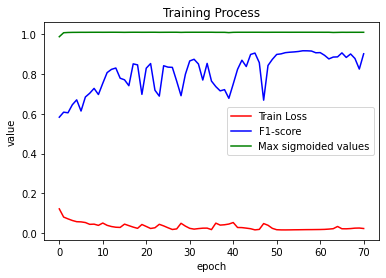

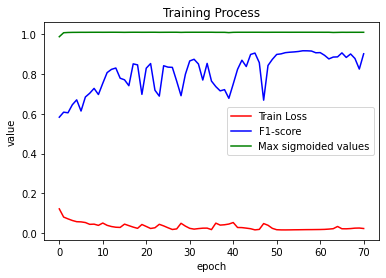

 - Saving Model...
 - Saving Model...
_____ Train Epoch 71 _____
_____ Train Epoch 71 _____
Epoch 71 | Batch 0 - Train loss = 0.014506 - Max mask value = 0.999996
Epoch 71 | Batch 0 - Train loss = 0.014506 - Max mask value = 0.999996
Epoch 71 | Batch 1 - Train loss = 0.019825 - Max mask value = 0.999981
Epoch 71 | Batch 1 - Train loss = 0.019825 - Max mask value = 0.999981
Epoch 71 | Batch 2 - Train loss = 0.019640 - Max mask value = 0.999951
Epoch 71 | Batch 2 - Train loss = 0.019640 - Max mask value = 0.999951
Epoch 71 | Batch 3 - Train loss = 0.022954 - Max mask value = 0.999754
Epoch 71 | Batch 3 - Train loss = 0.022954 - Max mask value = 0.999754
Epoch 71 | Batch 4 - Train loss = 0.022200 - Max mask value = 0.999922
Epoch 71 | Batch 4 - Train loss = 0.022200 - Max mask value = 0.999922
Epoch 71 | Batch 5 - Train loss = 0.014603 - Max mask value = 0.999941
Epoch 71 | Batch 5 - Train loss = 0.014603 - Max mask value = 0.999941
Epoch 71 | Batch 6 - Train loss = 0.038341 - Max mask va

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

In [ ]:
threshold = 0.5
epoches = []
train_losses = []
max_sigmoided = []
f1_scores = []

for epoch in range(last_epoch, EPOCHES):
    print("_____ Train Epoch %d _____" % epoch)
    start = time.time()
    epoch_loss = 0.
    max_sigm_epoch = 0.
    train_dataset = train_dataset_regenerate(train_ids)

    # ----------------- Train ----------------- #
    for i, train_batch in enumerate(train_dataset):

        # Get images
        train_forgery, train_gt = train_batch
        train_gt = tf.image.rgb_to_grayscale(train_gt)
        
        # Learn
        with tf.GradientTape() as rru_tape:
            out = rru_net(train_forgery)
            out_probs = tf.keras.activations.sigmoid(out)
            out_probs_flatten = tf.reshape(out_probs, [-1])
            train_gt_flatten = tf.reshape(train_gt, [-1])
            train_loss = loss(train_gt_flatten, out_probs_flatten)
        rru_gradients = rru_tape.gradient(train_loss, rru_net.trainable_variables)
        rru_optimizer.apply_gradients(zip(rru_gradients, rru_net.trainable_variables))
        max_mask_value = tf.math.reduce_max(out_probs).numpy()

        print("Epoch %d | Batch %d - Train loss = %f - Max mask value = %f" % (epoch, i, train_loss, max_mask_value))
        max_sigm_epoch += max_mask_value
        epoch_loss += train_loss.numpy()


    # ---------------- Evaluate ---------------- #
    tot_F_measure = 0.
    epoches.append(epoch)
    train_losses.append(epoch_loss / i)
    max_sigmoided.append(max_sigm_epoch / i)
    print("Evaluation ...")    

    for j, val_batch in enumerate(val_dataset):

        # Get images
        val_forgery, val_gt = val_batch
        val_gt = tf.squeeze(tf.image.rgb_to_grayscale(val_gt))

        for v_forg, v_gt in zip(val_forgery, val_gt):

            # Compute rru output mask
            v_forg = tf.expand_dims(v_forg, 0)
            out = rru_net(v_forg)
            out_gray = tf.squeeze(out)
            out_mask = tf.cast(tf.keras.activations.sigmoid(out_gray) > threshold, dtype=tf.float32)

            # Compute F-measure
            v_gt = tf.expand_dims(v_gt, 0)
            intersection = tf.math.reduce_sum(tf.math.multiply(out_mask, v_gt))
            union = tf.math.reduce_sum(out_mask) + tf.math.reduce_sum(v_gt) + 1e-5
            tot_F_measure += 2 * intersection.numpy() / union.numpy()
    
    f1_scores.append(tot_F_measure / VAL_SIZE)
    print("Epoch %d completed in %f seconds | medium loss = %f | F1-score = %f" % (epoch, time.time() - start, train_losses[epoch], f1_scores[epoch]))
    
    # Plot train process
    fig = plt.figure()

    plt.title('Training Process')
    plt.xlabel('epoch')
    plt.ylabel('value')
    l1, = plt.plot(epoches, train_losses, c='red')
    l2, = plt.plot(epoches, f1_scores, c='blue')
    l3, = plt.plot(epoches, max_sigmoided, c='green')

    plt.legend(handles=[l1, l2, l3], labels=['Train Loss', 'F1-score', 'Max sigmoided values'], loc='best')
    plt.show()

    if epoch % CHECKPOINT_PERIOD == 0 and epoch > 0:
        print(" - Saving Model...")
        save_path = checkpoint.save(CHECKPOINT_FILEPATH)

**Evaluation**

Evaluation ...


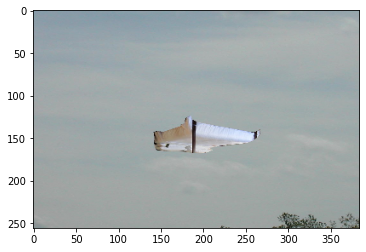

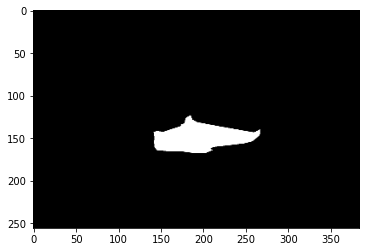

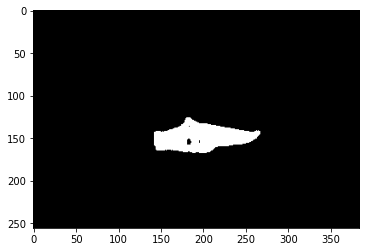

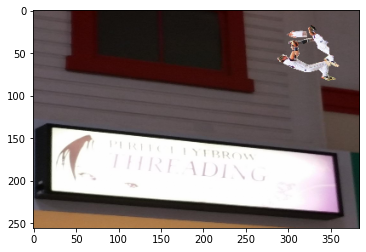

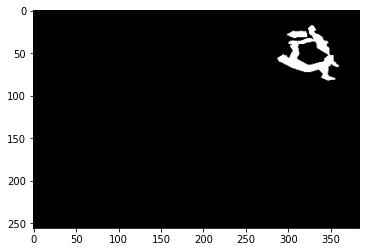

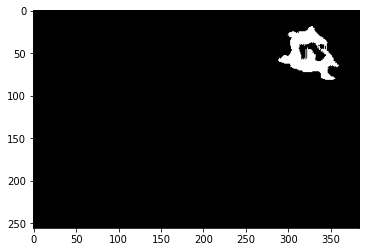

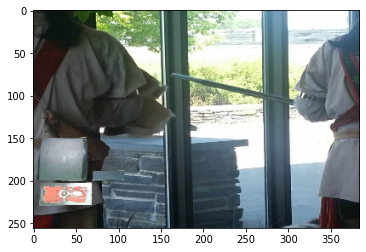

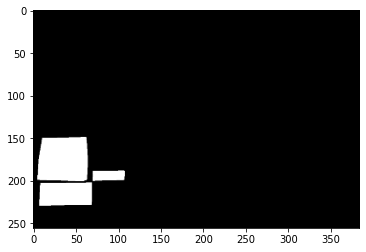

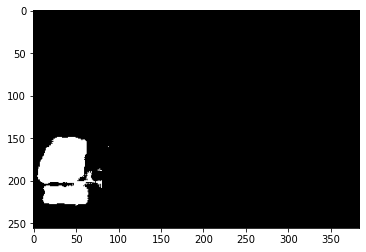

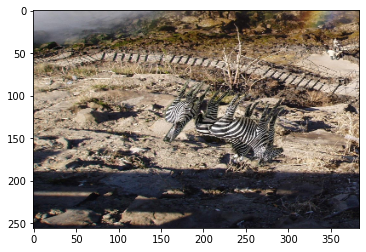

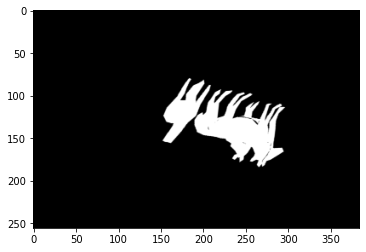

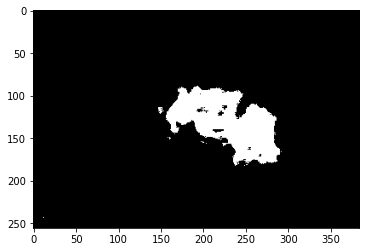

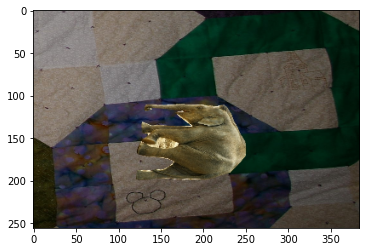

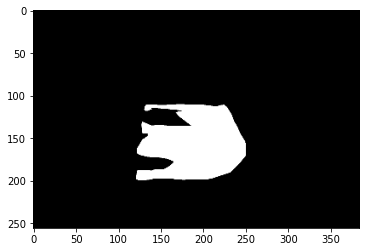

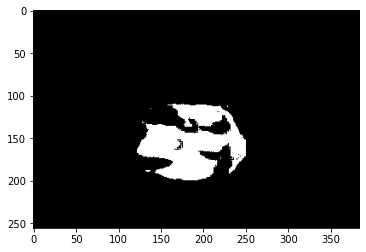

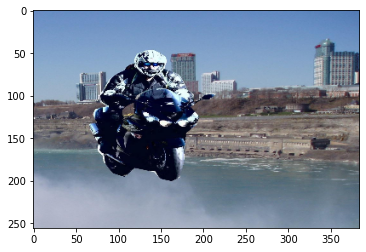

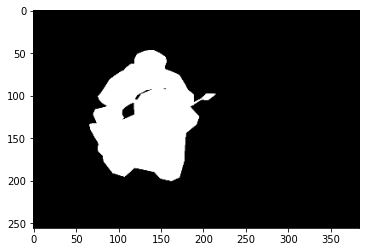

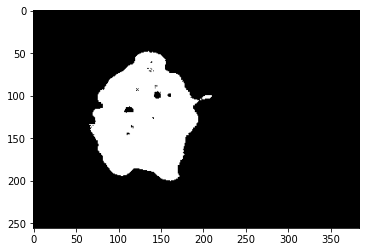

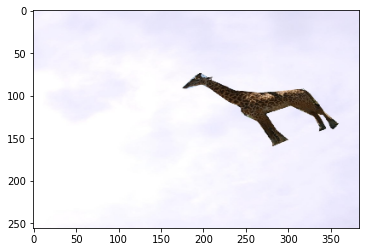

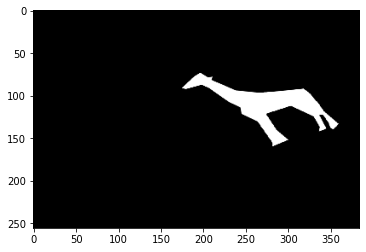

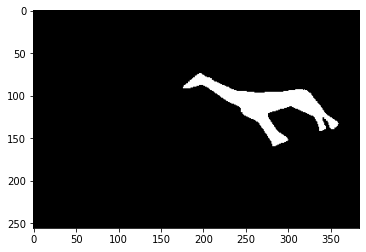

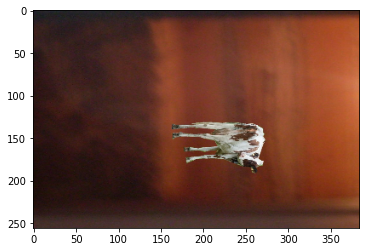

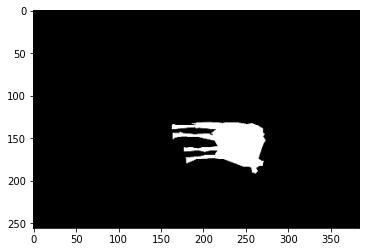

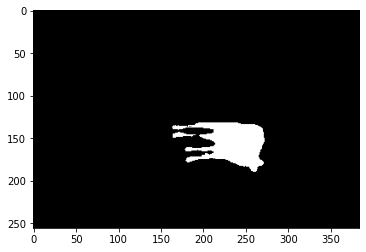

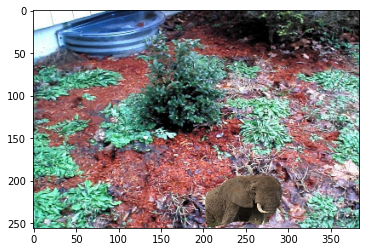

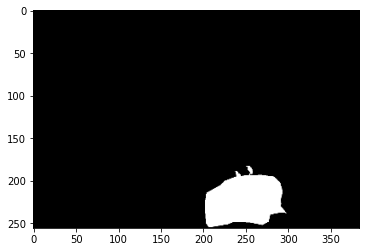

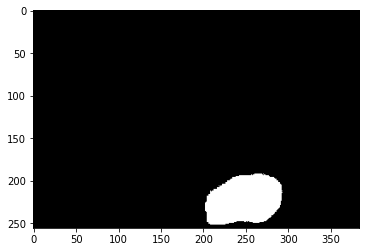

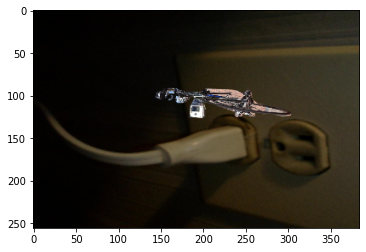

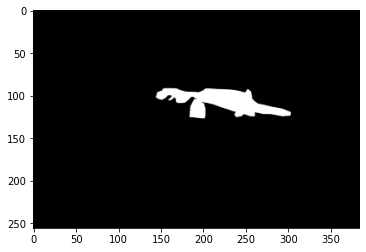

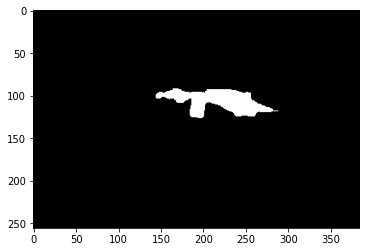

F1-score = 0.9058768685153945


In [17]:
tot_F_measure = 0.
threshold = 0.5
print("Evaluation ...")    

for j, val_batch in enumerate(val_dataset):
    # Get images
    val_forgery, val_gt = val_batch
    val_gt = tf.squeeze(tf.image.rgb_to_grayscale(val_gt))

    for v_forg, v_gt in zip(val_forgery, val_gt):

        # Compute rru output mask
        v_forg = tf.expand_dims(v_forg, 0)
        out = rru_net(v_forg)
        out_gray = tf.squeeze(out)
        out_mask = tf.cast(tf.keras.activations.sigmoid(out_gray) > threshold, dtype=tf.float32)

        # Show imgs
        plt.imshow(tf.squeeze(v_forg))
        plt.show()
        plt.imshow(v_gt, cmap='gray')
        plt.show()
        plt.imshow(out_mask, cmap='gray')
        plt.show()

        # Compute F-measure
        v_gt = tf.expand_dims(v_gt, 0)
        intersection = tf.math.reduce_sum(tf.math.multiply(out_mask, v_gt))
        union = tf.math.reduce_sum(out_mask) + tf.math.reduce_sum(v_gt) + 1e-5
        tot_F_measure += 2 * intersection.numpy() / union.numpy()

print("F1-score =", tot_F_measure / VAL_SIZE)

## Noise and Compression attacks

In [16]:
from albumentations.augmentations.transforms import (
    VerticalFlip, HorizontalFlip, JpegCompression, GaussNoise)
import os
import shutil

In [15]:
# Test set initialization
if DATASET_NAME == 'CASIA':
    test_set = [f.replace('.tif', '.jpg') for f in test_set]
elif DATASET_NAME == 'Spliced_COCO':
    test_set = [f.replace('.png', '.jpg') for f in test_set]
trial_index = 1
path_img = DATA_DIR + DATASET_NAME + '/' + FORGERED_FOLDER
path_mask = DATA_DIR + DATASET_NAME + '/' + GROUND_TRUTH_FOLDER
attack = 'Gaussian_Noise'
#attack = 'Jpeg_Compression'

**Noise**

In [16]:
# Noisy data generation
if attack == 'Gaussian_Noise':
  print("\nGaussian Noise attack with variance =", NOISE_VARIANCES[trial_index], "\n")
  for i in tqdm(test_set):
      name = i.split('.')[0]
      img = os.path.join(path_img, i) 
      mask = os.path.join(path_mask, '{}_gt.png'.format(name)) 
      image = io.imread(img) 
      mask = io.imread(mask)

      whatever_data = "my name"

      augmentation = GaussNoise(var_limit=NOISE_VARIANCES[trial_index], p=1.0)
      data = {"image": image, "mask": mask, "whatever_data": whatever_data, "additional": "hello"}
      augmented = augmentation(**data)
      image_g, mask_g, whatever_data, additional = augmented["image"], augmented["mask"], augmented["whatever_data"], augmented["additional"]
      io.imsave(os.path.join(path_img, '{}_G.jpg'.format(name)), image_g, quality=100)
      io.imsave(os.path.join(path_mask, '{}_G_gt.png'.format(name)), mask_g)

  0%|          | 0/45 [00:00<?, ?it/s]

Gaussian Noise attack with variance = 0.004 



100%|██████████| 45/45 [00:11<00:00,  3.92it/s]


**Compression**

In [ ]:
# Compressed data generation
if attack == 'JPEG_COMPRESSION':
  print("\nJPEG Compression attack with quality =", COMPRESSION_QUALITIES[trial_index], "\n")
  for i in tqdm(test_set):
      name = i.split('.')[0]
      img = os.path.join(path_img, i) 
      mask = os.path.join(path_mask, '{}_gt.png'.format(name)) 
      image = io.imread(img) 
      mask = io.imread(mask)

      quality = COMPRESSION_QUALITIES[trial_index]
      io.imsave(os.path.join(path_img, '{}_q.jpg'.format(name)), image, quality=quality)
      io.imsave(os.path.join(path_mask, '{}_q_gt.png'.format(name)), mask)

**Evaluation on the corrupted test set**

In [ ]:
tot_F_measure = 0.
threshold = 0.5
print("Evaluation ...")    

for j, test_batch in enumerate(test_dataset):
    # Get images
    test_forgery, test_gt = test_batch
    test_gt = tf.squeeze(tf.image.rgb_to_grayscale(test_gt))

    for t_forg, t_gt in zip(test_forgery, test_gt):

        # Compute rru output mask
        t_forg = tf.expand_dims(t_forg, 0)
        out = rru_net(t_forg)
        out_gray = tf.squeeze(out)
        out_mask = tf.cast(tf.keras.activations.sigmoid(out_gray) > threshold, dtype=tf.float32)

        # Show images
        plt.imshow(tf.squeeze(t_forg))
        plt.show()
        plt.imshow(t_gt, cmap='gray')
        plt.show()
        plt.imshow(out_mask, cmap='gray')
        plt.show()

        # Compute F-measure
        t_gt = tf.expand_dims(t_gt, 0)
        intersection = tf.math.reduce_sum(tf.math.multiply(out_mask, t_gt))
        union = tf.math.reduce_sum(out_mask) + tf.math.reduce_sum(t_gt) + 1e-5
        tot_F_measure += 2 * intersection.numpy() / union.numpy()

print("F1-score =", tot_F_measure / TEST_SIZE)

Evaluation ...
